# FYP - Pipeline

This notebook contains the code required for the pipeline only excluding any code used for testing.

### Required Libraries

In [1]:
# pip install ultralytics

In [2]:
# pip install clip-retrieval img2dataset

import numpy as np
import cv2
import urllib.request
import os
import csv
import tensorflow
import urllib.request

from clip_retrieval.clip_client import ClipClient, Modality
from matplotlib import pyplot as plt
from deepface import DeepFace
from pathlib import Path
from tqdm import tqdm

from matplotlib import pyplot as plt
import cv2
import numpy as np
from ultralytics import YOLO
import tensorflow as tf
import torch
import math

### Extra Function 

In [3]:
# Function used to display the images alongside their relevant data
def ImageInfoDisplay(imageDict):
    # Looping through all the images
    for itemIndex in range(len(imageDict.items())):
        
        # Displaying the relevant image
        plt.imshow(imageDict[itemIndex][0], interpolation='nearest', cmap="gray")
        plt.axis("Off")
        text = ""
        
        # Determining the data to display based on the API used 
        # since not all API's provide the same resultant metrics
        if 'age' in imageDict[itemIndex][1]:
            text += "Age: " + str(imageDict[itemIndex][1]['age'])
        
        if 'gender' in imageDict[itemIndex][1]:
            text += "\nGender: " + str(imageDict[itemIndex][1]['gender'])
            
        if 'race' in imageDict[itemIndex][1]:
            text += "\nRace: " + str(imageDict[itemIndex][1]['race'])
            
        if 'emotion' in imageDict[itemIndex][1]:
            text += "\nEmotion:" + str(imageDict[itemIndex][1]['emotion'])
        
        plt.text(0, imageDict[itemIndex][0].shape[0]-10, text, color='red')
        plt.show()

In [4]:
# Function used to convert sentences to camel case and removes spaces
# Note: This is used further down to specify folder names
def CamelCase(text):
    # Splitting the text into words by space
    words = text.split()

    # Capitalising the first letter of each word
    camel_case_words = (word.capitalize() for word in words)

    # Joining the words together to form the CamelCase string
    camel_case_text = ''.join(camel_case_words)

    return camel_case_text

In [20]:
# Function used to load images from a specified folder
# can be used to load custom dataset or images already retrived via CLIP
def LoadImagesFromFolder(folder_path):

    # Initialize an empty list to store the loaded images
    image_list = []

    list_of_files = os.listdir(folder_path)

    # Loop through the files in the folder
    for file_no in range(len(list_of_files)):
        filename = str(file_no)+".jpg"
        if filename in list_of_files:
            # Construct the full path to the image file
            image_path = os.path.join(folder_path, filename)

            # Load the image using cv2 in BGR format
            image_bgr = cv2.imread(image_path)

            if image_bgr is not None:
                # Convert BGR to RGB format
                image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

                # Append the RGB image to the list
                image_list.append(image_rgb)
    
    return image_list

In [6]:
# Function used to access the images & output_data.csv file to load the necessary data & metrics to be used by the program
def LoadMetricCSVFromFolder(csv_file_path):
    data_dict = {}

    with open(csv_file_path+"\\output_data.csv", mode='r', newline='') as file:
        reader = csv.DictReader(file)
        for row in reader:
            image_no = int(row['Image_No'])
            
            image = cv2.cvtColor(cv2.imread(csv_file_path+"\\"+str(image_no)+".jpg"), cv2.COLOR_BGR2RGB)
            
            data_dict[image_no] = [image,{
                'Age': int(row['Age']),
                'Gender': row['Gender'],
                'Race': row['Race'],
                'Emotion': row['Emotion']
            }]

    return data_dict

In [7]:
# # Function used to measure the similarity between two images utilising the MSE
# def ImageSimilarity(img1, img2, threshold=1000):

#     # Checking if the images have the same dimensions
#     # if img1.shape != img2.shape:
#     img1 = cv2.resize(img1, [256,256])
#     img2 = cv2.resize(img2, [256,256])
#         # return False

#     # Calculate the Mean Squared Error (MSE)
#     mse = ((img1 - img2) ** 2).mean()
    
#     print(mse)

#     # Compare MSE with threshold
#     return mse < threshold

In [8]:
# # Function used to remove duplicate images from list
# def return_non_duplicate_image_indexes(list_images, threshhold=1000):
#     no_duplicate_indexes = []

#     for index in range(len(list_images)):
#         unique = True
#         for index_2 in range(index, len(list_images)):
#             if index != index_2:
#                 if ImageSimilarity(list_images[index], list_images[index_2], threshhold):
#                     unique = False
#                     break

#         if unique:
#             no_duplicate_indexes.append(index)

#     return no_duplicate_indexes


### LAION-5B Image Retrievel

In [9]:
# Code-Link: https://colab.research.google.com/github/rom1504/clip-retrieval/blob/master/notebook/clip-client-query-api.ipynb#scrollTo=LtInBZF-vTuE
# https://github.com/rom1504/clip-retrieval

In [10]:
# Function used to retrive image links from the LAION-5B dataset 
def RetrieveImageLinks(text, aes_score, aes_weight, num_of_images):
    # Connecting to the Clip client
    client = ClipClient(
        url="https://knn.laion.ai/knn-service",
        indice_name="laion5B-H-14",
        aesthetic_score=aes_score,
        aesthetic_weight=aes_weight,
        modality=Modality.IMAGE,
        num_images=num_of_images,
        deduplicate=True,
    )
    
    print(text)
    
    # Retrieving the image links based on the text query
    img_result = client.query(text)
        
    return img_result

In [11]:
# Function used to attempt to convert image links into proper images
def RetrieveImagesFromLinks(listOfImageLinks):
    images = []
    
    # Progress bar used to keep track of process execution
    progress_bar = tqdm(total=len(listOfImageLinks), desc="Processing", unit="links")
    
    # Counter used to keep track of how many images were not retrieved
    failedToGetImageCounter = 0
    
    for img_url in listOfImageLinks:
        try:
            # timeout added in case image takes too long to retrive from link 
            image_data = urllib.request.urlopen(img_url['url'], timeout=10)
            
            # Converting the image to .jpg
            img = plt.imread(image_data, format='jpg')
            
            # Checking that the image is of the correct type
            if img.dtype != np.uint8:
                # Fixing images of type float32
                if img.dtype == np.float32:
                    img = (img * 255).astype(np.uint8)
            
            # Adding the image to images list
            images.append(img)
        except Exception as error:
            failedToGetImageCounter+=1
        
        # Updating the progress bar
        progress_bar.update(1)
    
    return images, failedToGetImageCounter

In [12]:
# Function used to combine the functionality of the RetrieveImages & RetrieveImagesFromLinks functions
# Note: This function ensures that the requested number of images are retrieved irrelevant of any errors 
# and provides the added functionality of saving the images retrieved to disk
# Note: Requesting too many images will result in errors, if the specified numebr of images doesn't exist
def RetrieveImagesLAION(text, aes_score, aes_weight, num_of_images, save_images):
    images = []
    
    # Increasing the number of images required in case some images were failed to be retrieved
    noImages = num_of_images*2 
    
    while len(images) < num_of_images:
        # Retrieving the image urls from LAION-5B dataset
        image_links = RetrieveImageLinks(text, aes_score, aes_weight, noImages)

        # Retrieving the images from their respective urls
        images, failedImages = RetrieveImagesFromLinks(image_links)
        
        # Increasing the number of images required in case some images were failed to be retrieved
        noImages = noImages*2
    
    # Removing any extra images 
    images = images[:num_of_images]
    print("Out of the ",len(image_links)," image links retrieved ",failedImages," failed to result in an image.")
    
    if save_images:
        # Checking if the folder exists, and if not, creating it
        folder_path = Path("DownloadedImages")
        if not folder_path.exists():
            folder_path.mkdir()
    
        # Checking if the folder exists, and if not, creating it
        sub_folder_path = Path(os.path.join("DownloadedImages",CamelCase(text)))
        if not sub_folder_path.exists():
            sub_folder_path.mkdir()
        
        # Saving the images to disk
        for imgIndex in range(len(images)):
            save_path = os.path.join(sub_folder_path,str(imgIndex)+".jpg")
            cv2.imwrite(save_path, cv2.cvtColor(images[imgIndex], cv2.COLOR_BGR2RGB))
    return images

In [13]:
# Function used to save the data of the DeepFaceProcess as a csv (Used only in DeepFaceProcess function)
def SaveMetricsCSV(sub_folder_path, metric_dict):
    # Specifying the CSV file path
    csv_file_path = Path(os.path.join(sub_folder_path, 'output_data.csv'))

    # Opening the CSV file for writing
    with open(csv_file_path, mode='w', newline='') as file:
        fieldnames = ['Image_No','Age', 'Gender', 'Race', 'Emotion']
        writer = csv.DictWriter(file, fieldnames=fieldnames)

        # Writing the header row
        writer.writeheader()

        # Writing the image properties to the CSV file
        for image_name, properties in metric_dict.items():
            writer.writerow({
                'Image_No': image_name,
                'Age': properties[1]["age"],
                'Gender': properties[1]["gender"],
                'Race': properties[1]["race"],
                'Emotion': properties[1]["emotion"]
            })

In [170]:
# Function used to detect the face with the largest area in the image
def FindObjWithLargestArea(objs):
    largestArea = 0
    imageIndex = 0

    for index, obj in enumerate(objs):
        if obj['region']['w'] * obj['region']['h'] > largestArea:
            largestArea = obj['region']['w'] * obj['region']['h']
            imageIndex = index
    return imageIndex

In [171]:
# This function is an improved implementation of the previous DeepFaceProcess function, 
# having multi face detection capabilites whilst using the mtcnn detector backend  
def DeepFaceProcess(listOfImages,prompt_used,save_metrics):
    tensorflow.keras.utils.disable_interactive_logging()
    DeepFaceDict = {}
    counter = 0
    
    # Create a tqdm progress bar
    progress_bar = tqdm(total=len(listOfImages), desc="Processing", unit="images")
    
    for imgIndex in range(len(listOfImages)):
        try:
            # Retrieving the age/gender/race/emotion of the image
            # Note: enforce_detection=False used so that images where the face isn't fully visible are still considered
            # Note: silent=True used to remove in built progress bar
            image =  listOfImages[imgIndex][:,:,:3]

            objs = DeepFace.analyze(image, actions = ['age', 'gender', 'race', 'emotion'], enforce_detection=False,  detector_backend="mtcnn", silent=True)
            
            # for index in range(len(objs)): 
            # #Removed since each image will only contain one face 
            # given that each images is being seperated into individual persons beforehand via the YOLODetectPerson function
            # index = 0

            # Using the index of the primary face (takes up most area) in the image
            index =  FindObjWithLargestArea(objs)
            
            if objs[index]['dominant_gender'] == "Man":
                ImageInfo = {'age':objs[index]['age'], 'gender':"Male", 'race':objs[index]['dominant_race'], 'emotion':objs[index]['dominant_emotion']}
            elif objs[index]['dominant_gender'] == "Woman":
                ImageInfo = {'age':objs[index]['age'], 'gender':"Female", 'race':objs[index]['dominant_race'], 'emotion':objs[index]['dominant_emotion']}
            
            # Cropping the image to only include the face
            objs[index]['region']
            x = objs[index]['region']['x']
            y = objs[index]['region']['y']
            width = objs[index]['region']['x'] + objs[index]['region']['w']
            height = objs[index]['region']['y'] + objs[index]['region']['h']
            croppedImg = listOfImages[imgIndex][y:height, x:width]
            
            # Storing the images in a dictionary 
            DeepFaceDict[counter] = [croppedImg,ImageInfo]
            counter+=1
        except Exception as error:
            counter-=1
            plt.imshow(listOfImages[imgIndex][:,:,:3])
            plt.show()
            print("Error: ",error)
            
        # Update the progress bar
        progress_bar.update(1)
    
    if save_metrics:
        # Checking if the folder exists, and if not, creating it
        sub_folder_path = Path("DownloadedImages\\"+CamelCase(prompt_used)+"\\ImagesMetrics")
        if not sub_folder_path.exists():
            sub_folder_path.mkdir()
        
        # Saving the metrics to csv file
        SaveMetricsCSV(sub_folder_path, DeepFaceDict)
        
        # Saving the cropped images used by the DeepFace API to disk
        for imgIndex in range(len(DeepFaceDict.items())):
            save_path = os.path.join(sub_folder_path,str(imgIndex)+".jpg")
            cv2.imwrite(save_path, cv2.cvtColor(DeepFaceDict[imgIndex][0], cv2.COLOR_BGR2RGB))
    return DeepFaceDict

In [15]:
# Function used to combine the the functionality of the RetrieveImagesLAION, DeepFaceProcess & ImageInfoDisplay functions
def SearchQueryFunc(text, aes_score,aes_weight, num_of_images):
  
    list_of_images = RetrieveImagesLAION(text, aes_score, aes_weight, num_of_images, False)  
        
    # Processign the images via DeepFace API
    DeepFaceDict = DeepFaceProcess(list_of_images,text,False)
    
    # Displaying the image & their information
    ImageInfoDisplay(DeepFaceDict)

A picture of a doctor


Processing: 100%|██████████| 17/17 [00:30<00:00,  1.82s/links]


Out of the  17  image links retrieved  7  failed to result in an image.


Processing: 100%|██████████| 10/10 [00:20<00:00,  2.02s/images]


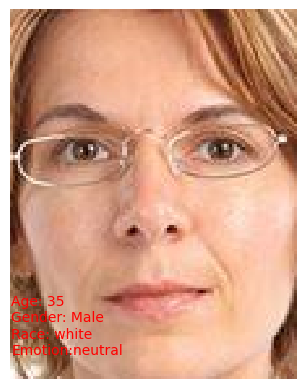

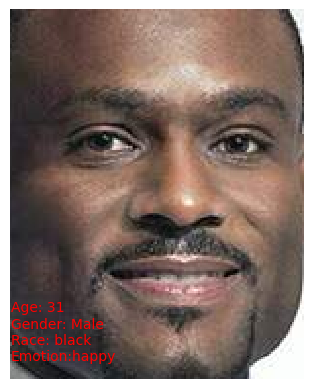

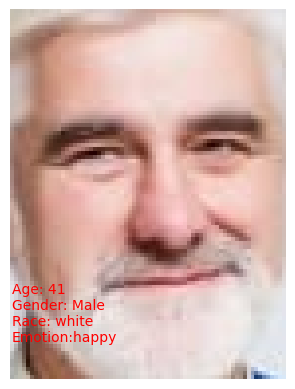

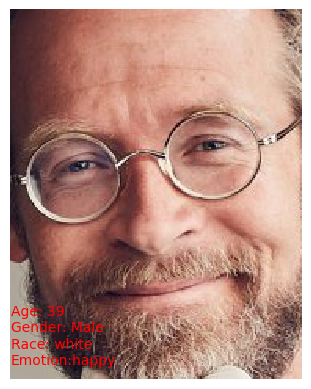

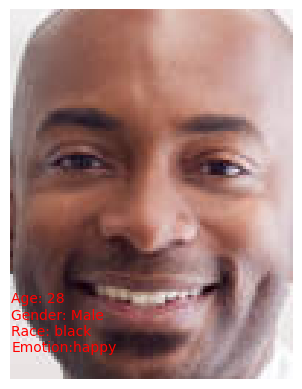

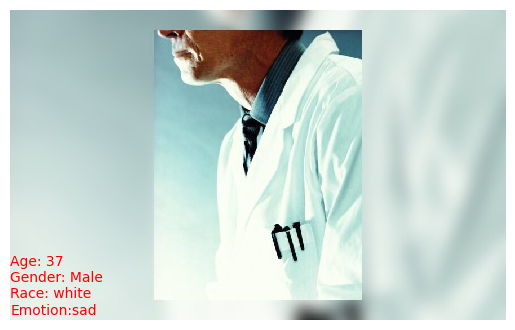

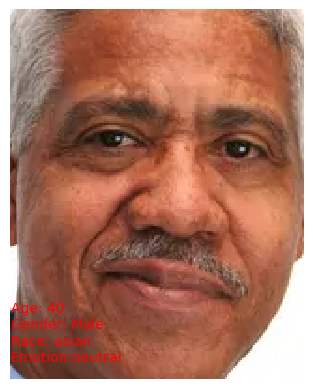

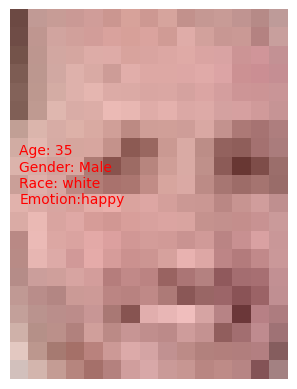

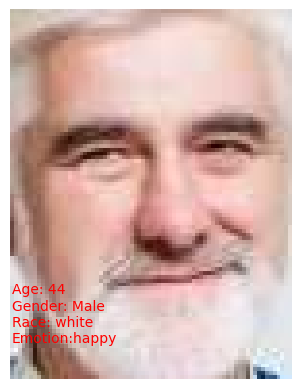

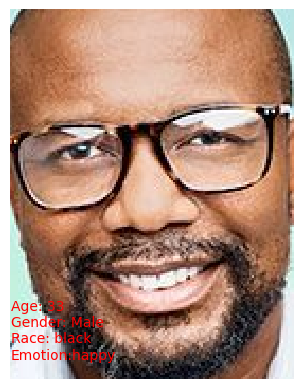

In [16]:
text = "A picture of a doctor"
aes_score = 9
aes_weight = 0.5
num_of_images = 10
SearchQueryFunc(text, aes_score,aes_weight, num_of_images)

#### Metric Display

In [16]:
# Function used to measure gender metrics in relation to the DeepFace data passed
def MetricGenderDisplay(data, specific_race, specific_emotion, specific_age):
    
    # Gender labels - assumes only two genders
    genders = ['Male', 'Female']
    count = [0, 0]
    
    # Looping through the instances in the data
    for instance in data:
        
        # Enforcing race constraints 
        if specific_race != None:
            if data[instance][1]["race"].lower() != specific_race.lower():
                continue
          
         # Enforcing emotion constraints 
        if specific_emotion != None:
            if data[instance][1]["emotion"].lower() != specific_emotion.lower():
                continue
        
        # Enforcing age constraints 
        if specific_age != None:
            if data[instance][1]["age"] != specific_age:
                continue
        
        # Retrieving instance gender
        mGender = data[instance][1]["gender"].lower()
        
        # Incrementing counters
        if mGender == "male":
            count[0]+=1
        elif mGender == "female":
            count[1]+=1
        else:
            print("Invalid Gender Detected: ",mGender)
    
    # Creating bar chart
    plt.bar(genders, count)

    # Adding labels and title
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.title('Male vs. Female Distribution')

    # Showing the plot
    plt.show()

In [17]:
# Function used to measure race metrics in relation to the DeepFace data passed
def MetricRaceDisplay(data, specific_gender, specific_emotion, specific_age):
    
    # Race labels - assumes races detected by DeepFace
    races = ["asian", "white", "middle eastern", "indian", "latino", "black", "latino hispanic"]
    count = [0,0,0,0,0,0,0] 

    # Looping through the instances in the data
    for instance in data:
        
        # Enforcing gender constraints 
        if specific_gender != None:
            if data[instance][1]["gender"].lower() != specific_gender.lower():
                continue
                
        # Enforcing emotion constraints 
        if specific_emotion != None:
            if data[instance][1]["emotion"].lower() != specific_emotion.lower():
                continue
                
        # Enforcing age constraints         
        if specific_age != None:
            if data[instance][1]["age"] != specific_age:
                continue
        
        # Retrieving instance race
        mRace = data[instance][1]["race"].lower()
        
        # Incrementing counters
        if mRace == "asian":
            count[0]+=1
        elif mRace == "white":
            count[1]+=1
        elif mRace == "middle eastern":
            count[2]+=1
        elif mRace == "indian":
            count[3]+=1
        elif mRace == "latino":
            count[4]+=1
        elif mRace == "black":
            count[5]+=1
        elif mRace == "latino hispanic":
            count[6]+=1    
        else:
            print("Invalid Race Detected: ", mRace)

    # Creating bar chart
    plt.bar(races, count)

    # Adding labels and title
    plt.xlabel('Races')
    plt.ylabel('Count')
    plt.title('Race Distribution')

    # Showing the plot
    plt.show()

In [18]:
# Function used to measure emotion metrics in relation to the DeepFace data passed
def MetricEmotionDisplay(data, specific_gender, specific_race, specific_age):
    
    # Emotion labels - assumes emotions detected by DeepFace
    emotions = ["angry", "fear", "neutral", "sad", "disgust", "happy", "surprise"]
    count = [0,0,0,0,0,0,0]

    # Looping through the instances in the data
    for instance in data:
        
        # Enforcing gender constraints 
        if specific_gender != None:
            if data[instance][1]["gender"].lower() != specific_gender.lower():
                continue
                
        # Enforcing race constraints 
        if specific_race != None:
            if data[instance][1]["race"].lower() != specific_race.lower():
                continue
                
        # Enforcing age constraints 
        if specific_age != None:
            if data[instance][1]["age"] != specific_age:
                continue
    
        # Retrieving instance emotion
        mEmotion = data[instance][1]["emotion"].lower()
        
        # Incrementing counters
        if mEmotion == "angry":
            count[0]+=1
        elif mEmotion == "fear":
            count[1]+=1
        elif mEmotion == "neutral":
            count[2]+=1
        elif mEmotion == "sad":
            count[3]+=1
        elif mEmotion == "disgust":
            count[4]+=1
        elif mEmotion == "happy":
            count[5]+=1
        elif mEmotion == "surprise":
            count[6]+=1
        else:
            print("Invalid Emotion Detected: ", mEmotion)

    # Creating bar chart
    plt.bar(emotions, count)

    # Adding labels and title
    plt.xlabel('Emotions')
    plt.ylabel('Count')
    plt.title('Emotion Distribution')

    # Showing the plot
    plt.show()

In [19]:
# Function used to measure age metrics in relation to the DeepFace data passed
def MetricAgeDisplay(data, specific_gender, specific_race, specific_emotion):
    
    # Age group labels seperated in intervals of ten
    age_groups = ['1-10', '11-20', '21-30', '31-40', '41-50','51-60', '61-70', '71-80', '81-90', '91-100']
    count = [0,0,0,0,0,0,0,0,0,0] 
    
    # Looping through the instances in the data
    for instance in data:
        
        # Enforcing gender constraints 
        if specific_gender != None:
            if data[instance][1]["gender"].lower() != specific_gender.lower():
                continue
                
        # Enforcing race constraints          
        if specific_race != None:
            if data[instance][1]["race"].lower() != specific_race.lower():
                continue
                
        # Enforcing emotion constraints         
        if specific_emotion != None:
            if data[instance][1]["emotion"].lower != specific_emotion.lower():
                continue
    
        # Retrieving instance age
        mAge = data[instance][1]["age"]
        
        # Incrementing counters
        if mAge >= 1 and mAge <= 10:
            count[0]+=1
        elif mAge >= 11 and mAge <= 20:
            count[1]+=1
        elif mAge >= 21 and mAge <= 30:
            count[2]+=1
        elif mAge >= 31 and mAge <= 40:
            count[3]+=1
        elif mAge >= 41 and mAge <= 50:
            count[4]+=1
        elif mAge >= 51 and mAge <= 60:
            count[5]+=1
        elif mAge >= 61 and mAge <= 70:
            count[6]+=1
        elif mAge >= 71 and mAge <= 80:
            count[7]+=1
        elif mAge >= 81 and mAge <= 90:
            count[8]+=1
        elif mAge >= 91 and mAge <= 100:
            count[9]+=1
        else:
            print("Invalid Age Detected: ", mAge)

    # Creating bar chart
    plt.bar(age_groups, count)
    
    # Adding labels and title
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.title('Age Group Distribution')
    
    # Showing the plot
    plt.show()

Processing:   0%|          | 0/100 [00:00<?, ?images/s]

[{'age': 25, 'region': {'x': 124, 'y': 57, 'w': 31, 'h': 39}, 'gender': {'Woman': 0.01104714028770104, 'Man': 99.98894929885864}, 'dominant_gender': 'Man', 'race': {'asian': 0.00034584436222326635, 'indian': 0.0073627005645193495, 'black': 3.63633255420672e-05, 'white': 88.66708807153034, 'middle eastern': 9.514880747489974, 'latino hispanic': 1.810287233310177}, 'dominant_race': 'white', 'emotion': {'angry': 31.193864345550537, 'disgust': 1.0060470145845102e-05, 'fear': 9.614763408899307, 'happy': 0.005852038520970382, 'sad': 46.88887894153595, 'surprise': 0.011333508155075833, 'neutral': 12.285299599170685}, 'dominant_emotion': 'sad'}]


Processing:   1%|          | 1/100 [00:07<12:13,  7.41s/images]

[{'age': 28, 'region': {'x': 146, 'y': 50, 'w': 32, 'h': 40}, 'gender': {'Woman': 0.013582583051174879, 'Man': 99.98641014099121}, 'dominant_gender': 'Man', 'race': {'asian': 32.73673057556152, 'indian': 6.065143272280693, 'black': 3.4468814730644226, 'white': 21.92170023918152, 'middle eastern': 12.43990883231163, 'latino hispanic': 23.38964343070984}, 'dominant_race': 'asian', 'emotion': {'angry': 0.00010544650876909145, 'disgust': 7.314737465909105e-11, 'fear': 4.353758598085733e-06, 'happy': 99.86342787742615, 'sad': 0.0002449419071126613, 'surprise': 0.002683561251615174, 'neutral': 0.1335367327556014}, 'dominant_emotion': 'happy'}]


Processing:   2%|▏         | 2/100 [00:08<05:57,  3.65s/images]

[{'age': 27, 'region': {'x': 152, 'y': 62, 'w': 32, 'h': 42}, 'gender': {'Woman': 0.012472255912143737, 'Man': 99.98753070831299}, 'dominant_gender': 'Man', 'race': {'asian': 1.788921574587916, 'indian': 9.415113742060289, 'black': 1.0845857387534223, 'white': 15.227054967108664, 'middle eastern': 53.11678964595733, 'latino hispanic': 19.36753507659048}, 'dominant_race': 'middle eastern', 'emotion': {'angry': 1.49055365473032, 'disgust': 0.015209217963274568, 'fear': 1.3582310639321804, 'happy': 79.16684150695801, 'sad': 9.509357064962387, 'surprise': 0.011924595310119912, 'neutral': 8.447885513305664}, 'dominant_emotion': 'happy'}]


Processing:   3%|▎         | 3/100 [00:09<03:57,  2.45s/images]

[{'age': 49, 'region': {'x': 153, 'y': 98, 'w': 35, 'h': 45}, 'gender': {'Woman': 0.10940233478322625, 'Man': 99.89060163497925}, 'dominant_gender': 'Man', 'race': {'asian': 2.7074158689479986, 'indian': 3.2682251014441133, 'black': 0.5228401935440071, 'white': 47.14424346157986, 'middle eastern': 24.8968139413817, 'latino hispanic': 21.460457568114094}, 'dominant_race': 'white', 'emotion': {'angry': 13.859567046165466, 'disgust': 3.8246165961027145, 'fear': 68.09155344963074, 'happy': 0.2822371432557702, 'sad': 13.081876933574677, 'surprise': 0.6653761956840754, 'neutral': 0.19476842135190964}, 'dominant_emotion': 'fear'}]


Processing:   4%|▍         | 4/100 [00:10<03:00,  1.88s/images]

[{'age': 31, 'region': {'x': 123, 'y': 70, 'w': 73, 'h': 92}, 'gender': {'Woman': 0.21985110361129045, 'Man': 99.78014826774597}, 'dominant_gender': 'Man', 'race': {'asian': 0.10084212427390363, 'indian': 9.92741538471848e-10, 'black': 9.422398319482059e-11, 'white': 99.89905356759152, 'middle eastern': 1.9164468488691097e-05, 'latino hispanic': 8.499702000368843e-05}, 'dominant_race': 'white', 'emotion': {'angry': 0.19946801476180553, 'disgust': 1.545917283074516e-08, 'fear': 0.07014464354142547, 'happy': 0.0005331749434844824, 'sad': 4.644247889518738, 'surprise': 0.011629324581008404, 'neutral': 95.07397413253784}, 'dominant_emotion': 'neutral'}]


Processing:   5%|▌         | 5/100 [00:11<02:33,  1.61s/images]

[{'age': 38, 'region': {'x': 88, 'y': 41, 'w': 37, 'h': 47}, 'gender': {'Woman': 0.005568553751800209, 'Man': 99.99443292617798}, 'dominant_gender': 'Man', 'race': {'asian': 1.5399286290573855e-07, 'indian': 1.1638172203731756e-06, 'black': 2.2651980985388676e-09, 'white': 99.95412826538086, 'middle eastern': 0.03364041622262448, 'latino hispanic': 0.012229419371578842}, 'dominant_race': 'white', 'emotion': {'angry': 7.020851348210622e-10, 'disgust': 2.5893332116981115e-21, 'fear': 1.1233286436457268e-10, 'happy': 99.99998807907104, 'sad': 3.1327898608601856e-09, 'surprise': 3.9823443750541115e-12, 'neutral': 1.3640396900882479e-05}, 'dominant_emotion': 'happy'}]


Processing:   6%|▌         | 6/100 [00:12<02:12,  1.41s/images]

Error:  Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Processing:   7%|▋         | 7/100 [00:13<01:44,  1.12s/images]

[{'age': 26, 'region': {'x': 157, 'y': 45, 'w': 30, 'h': 37}, 'gender': {'Woman': 0.0038918009522603825, 'Man': 99.99611377716064}, 'dominant_gender': 'Man', 'race': {'asian': 2.160534506856493e-05, 'indian': 0.00040654290387465153, 'black': 3.898663791801482e-06, 'white': 97.70979881286621, 'middle eastern': 1.7373992130160332, 'latino hispanic': 0.5523718427866697}, 'dominant_race': 'white', 'emotion': {'angry': 1.584651879966259, 'disgust': 1.784735731780529, 'fear': 9.743066877126694, 'happy': 32.77589976787567, 'sad': 11.633160710334778, 'surprise': 0.024650496197864413, 'neutral': 42.453837394714355}, 'dominant_emotion': 'neutral'}]


Processing:   8%|▊         | 8/100 [00:14<01:38,  1.07s/images]

[{'age': 22, 'region': {'x': 81, 'y': 22, 'w': 32, 'h': 41}, 'gender': {'Woman': 0.026099392562173307, 'Man': 99.97389912605286}, 'dominant_gender': 'Man', 'race': {'asian': 0.0038309843612909307, 'indian': 0.03196112128953613, 'black': 0.0017113755458528501, 'white': 87.07983416794742, 'middle eastern': 7.563814226616277, 'latino hispanic': 5.31884873323731}, 'dominant_race': 'white', 'emotion': {'angry': 0.04672837372926615, 'disgust': 2.914781034853004e-07, 'fear': 0.18685788331451317, 'happy': 0.0014803039421287386, 'sad': 1.1312425810839284, 'surprise': 5.230230924797446e-05, 'neutral': 98.63364092312104}, 'dominant_emotion': 'neutral'}]


Processing:   9%|▉         | 9/100 [00:15<01:37,  1.08s/images]

[{'age': 43, 'region': {'x': 133, 'y': 29, 'w': 38, 'h': 49}, 'gender': {'Woman': 2.9548846185207367, 'Man': 97.04511761665344}, 'dominant_gender': 'Man', 'race': {'asian': 0.10514298919588327, 'indian': 0.18329148879274726, 'black': 0.006244150426937267, 'white': 84.3226969242096, 'middle eastern': 9.979739785194397, 'latino hispanic': 5.402888357639313}, 'dominant_race': 'white', 'emotion': {'angry': 0.5954222287982702, 'disgust': 0.002418279109406285, 'fear': 3.8571789860725403, 'happy': 33.6645781993866, 'sad': 6.541179120540619, 'surprise': 0.001042448275256902, 'neutral': 55.33818006515503}, 'dominant_emotion': 'neutral'}]


Processing:  10%|█         | 10/100 [00:16<01:35,  1.06s/images]

[{'age': 26, 'region': {'x': 131, 'y': 24, 'w': 36, 'h': 49}, 'gender': {'Woman': 3.88750969193552e-06, 'Man': 100.0}, 'dominant_gender': 'Man', 'race': {'asian': 0.00011353296258675982, 'indian': 0.14338813489302993, 'black': 0.00014116476449999027, 'white': 11.217190325260162, 'middle eastern': 86.22854948043823, 'latino hispanic': 2.410617470741272}, 'dominant_race': 'middle eastern', 'emotion': {'angry': 11.014191061258316, 'disgust': 0.40906579233706, 'fear': 23.128020763397217, 'happy': 9.551049023866653, 'sad': 8.259788155555725, 'surprise': 0.5340826231986284, 'neutral': 47.10380434989929}, 'dominant_emotion': 'neutral'}]


Processing:  11%|█         | 11/100 [00:17<01:34,  1.06s/images]

[{'age': 25, 'region': {'x': 158, 'y': 55, 'w': 31, 'h': 42}, 'gender': {'Woman': 0.06892212550155818, 'Man': 99.93107318878174}, 'dominant_gender': 'Man', 'race': {'asian': 67.55033731460571, 'indian': 4.663527384400368, 'black': 1.2428413145244122, 'white': 8.691001683473587, 'middle eastern': 3.95595021545887, 'latino hispanic': 13.896344602108002}, 'dominant_race': 'asian', 'emotion': {'angry': 30.485665798187256, 'disgust': 2.73288544267416, 'fear': 30.05976378917694, 'happy': 0.0853104458656162, 'sad': 27.67307162284851, 'surprise': 0.21099147852510214, 'neutral': 8.752314001321793}, 'dominant_emotion': 'angry'}]


Processing:  12%|█▏        | 12/100 [00:18<01:35,  1.08s/images]

[{'age': 31, 'region': {'x': 92, 'y': 33, 'w': 35, 'h': 46}, 'gender': {'Woman': 0.10425427462905645, 'Man': 99.89573955535889}, 'dominant_gender': 'Man', 'race': {'asian': 27.30160355567932, 'indian': 31.772181391716003, 'black': 15.535716712474823, 'white': 5.242301896214485, 'middle eastern': 2.3354170843958855, 'latino hispanic': 17.812786996364594}, 'dominant_race': 'indian', 'emotion': {'angry': 0.3076330709164185, 'disgust': 1.2598824373770255e-11, 'fear': 0.00030033140290699415, 'happy': 5.573344642702718e-05, 'sad': 0.23873757131323645, 'surprise': 9.853226733404033e-06, 'neutral': 99.4532644422808}, 'dominant_emotion': 'neutral'}]


Processing:  13%|█▎        | 13/100 [00:19<01:32,  1.06s/images]

[{'age': 39, 'region': {'x': 153, 'y': 35, 'w': 35, 'h': 47}, 'gender': {'Woman': 0.0495585089083761, 'Man': 99.95044469833374}, 'dominant_gender': 'Man', 'race': {'asian': 1.3404750331582675e-07, 'indian': 8.049322799568967e-08, 'black': 5.275607956164491e-10, 'white': 99.98291134732433, 'middle eastern': 0.005687875066324141, 'latino hispanic': 0.01140477975006765}, 'dominant_race': 'white', 'emotion': {'angry': 7.717583230260061e-05, 'disgust': 3.2947353179046956e-09, 'fear': 0.00019102621990896296, 'happy': 99.99562501907349, 'sad': 5.072958231266966e-06, 'surprise': 0.0003159324023727095, 'neutral': 0.0037876670830883086}, 'dominant_emotion': 'happy'}]


Processing:  14%|█▍        | 14/100 [00:20<01:31,  1.06s/images]

[{'age': 33, 'region': {'x': 125, 'y': 44, 'w': 30, 'h': 40}, 'gender': {'Woman': 0.5135681945830584, 'Man': 99.4864284992218}, 'dominant_gender': 'Man', 'race': {'asian': 30.4688740056082, 'indian': 11.870274655239264, 'black': 10.031165780494558, 'white': 16.66977355896077, 'middle eastern': 12.41411119187541, 'latino hispanic': 18.545800062763696}, 'dominant_race': 'asian', 'emotion': {'angry': 1.8028389662504196, 'disgust': 1.2438814422921496e-07, 'fear': 2.8488827869296074, 'happy': 0.001423763569619041, 'sad': 48.40004742145538, 'surprise': 0.0003787450168601936, 'neutral': 46.94642722606659}, 'dominant_emotion': 'sad'}]


Processing:  15%|█▌        | 15/100 [00:21<01:29,  1.05s/images]

[{'age': 28, 'region': {'x': 139, 'y': 41, 'w': 30, 'h': 41}, 'gender': {'Woman': 0.0023403546947520226, 'Man': 99.9976634979248}, 'dominant_gender': 'Man', 'race': {'asian': 0.0002444233505398449, 'indian': 0.00028776002532926307, 'black': 1.0550092984122688e-05, 'white': 98.90272014753343, 'middle eastern': 0.4933011546463463, 'latino hispanic': 0.6034396482819109}, 'dominant_race': 'white', 'emotion': {'angry': 3.778833445449657, 'disgust': 0.0015471376147739452, 'fear': 7.505915909300338, 'happy': 0.544592766363291, 'sad': 8.972818079850903, 'surprise': 0.06525225857990878, 'neutral': 79.13103948461539}, 'dominant_emotion': 'neutral'}]


Processing:  16%|█▌        | 16/100 [00:22<01:28,  1.05s/images]

[{'age': 35, 'region': {'x': 131, 'y': 61, 'w': 48, 'h': 58}, 'gender': {'Woman': 0.010044180817203596, 'Man': 99.98995065689087}, 'dominant_gender': 'Man', 'race': {'asian': 0.8368552662432194, 'indian': 2.854728326201439, 'black': 1.4375264756381512, 'white': 36.744049191474915, 'middle eastern': 39.54429030418396, 'latino hispanic': 18.582545220851898}, 'dominant_race': 'middle eastern', 'emotion': {'angry': 0.02057000360589496, 'disgust': 0.0054476345731165375, 'fear': 0.2302772269935743, 'happy': 99.64921472365944, 'sad': 0.020315353805369366, 'surprise': 0.0012801428819288448, 'neutral': 0.07289483762836979}, 'dominant_emotion': 'happy'}]


Processing:  17%|█▋        | 17/100 [00:23<01:27,  1.05s/images]

[{'age': 20, 'region': {'x': 134, 'y': 104, 'w': 45, 'h': 61}, 'gender': {'Woman': 0.06596595630981028, 'Man': 99.93403553962708}, 'dominant_gender': 'Man', 'race': {'asian': 1.567235216498375, 'indian': 0.4144263453781605, 'black': 0.05162048037163913, 'white': 69.31673884391785, 'middle eastern': 11.20266392827034, 'latino hispanic': 17.447319626808167}, 'dominant_race': 'white', 'emotion': {'angry': 0.8918335661292076, 'disgust': 3.857338004564781e-07, 'fear': 0.032384105725213885, 'happy': 0.038670015055686235, 'sad': 4.159883409738541, 'surprise': 0.00040776890273264144, 'neutral': 94.87681984901428}, 'dominant_emotion': 'neutral'}]


Processing:  18%|█▊        | 18/100 [00:24<01:25,  1.04s/images]

[{'age': 44, 'region': {'x': 121, 'y': 30, 'w': 41, 'h': 55}, 'gender': {'Woman': 0.0001390227112096909, 'Man': 99.99985694885254}, 'dominant_gender': 'Man', 'race': {'asian': 11.428769677877426, 'indian': 16.77563637495041, 'black': 3.4632377326488495, 'white': 15.697124600410461, 'middle eastern': 14.623722434043884, 'latino hispanic': 38.01151216030121}, 'dominant_race': 'latino hispanic', 'emotion': {'angry': 0.007373665721388534, 'disgust': 7.162135329252806e-08, 'fear': 0.003202413790859282, 'happy': 96.3925838470459, 'sad': 0.028668539016507566, 'surprise': 0.0006726882929797284, 'neutral': 3.5675019025802612}, 'dominant_emotion': 'happy'}]


Processing:  19%|█▉        | 19/100 [00:25<01:22,  1.02s/images]

[{'age': 22, 'region': {'x': 117, 'y': 41, 'w': 31, 'h': 40}, 'gender': {'Woman': 0.007707816257607192, 'Man': 99.99228715896606}, 'dominant_gender': 'Man', 'race': {'asian': 9.285582602024078, 'indian': 6.020130962133408, 'black': 1.5332507900893688, 'white': 28.433087468147278, 'middle eastern': 18.734945356845856, 'latino hispanic': 35.993000864982605}, 'dominant_race': 'latino hispanic', 'emotion': {'angry': 1.763687500037638e-10, 'disgust': 5.618169050063654e-19, 'fear': 1.9702316040742838e-10, 'happy': 99.21303982812404, 'sad': 4.9430285729865915e-09, 'surprise': 6.370078533536314e-05, 'neutral': 0.7868969350693783}, 'dominant_emotion': 'happy'}]


Processing:  20%|██        | 20/100 [00:26<01:21,  1.02s/images]

[{'age': 35, 'region': {'x': 127, 'y': 35, 'w': 31, 'h': 42}, 'gender': {'Woman': 0.35195096861571074, 'Man': 99.64805245399475}, 'dominant_gender': 'Man', 'race': {'asian': 0.13852417469024658, 'indian': 0.5938711110502481, 'black': 0.05837593926116824, 'white': 72.43098020553589, 'middle eastern': 18.316733837127686, 'latino hispanic': 8.461514115333557}, 'dominant_race': 'white', 'emotion': {'angry': 20.710816979408264, 'disgust': 5.234971354184381e-05, 'fear': 66.68344736099243, 'happy': 4.028559476137161, 'sad': 0.1542650512419641, 'surprise': 1.5765642747282982, 'neutral': 6.846299767494202}, 'dominant_emotion': 'fear'}]


Processing:  21%|██        | 21/100 [00:27<01:20,  1.01s/images]

[{'age': 24, 'region': {'x': 120, 'y': 30, 'w': 53, 'h': 70}, 'gender': {'Woman': 0.0021035872123320587, 'Man': 99.9979019165039}, 'dominant_gender': 'Man', 'race': {'asian': 4.404011368751526, 'indian': 12.067237496376038, 'black': 3.3818483352661133, 'white': 17.073577642440796, 'middle eastern': 28.574076294898987, 'latino hispanic': 34.49925184249878}, 'dominant_race': 'latino hispanic', 'emotion': {'angry': 0.23637191870045177, 'disgust': 0.0041374804560781915, 'fear': 91.9358606300271, 'happy': 0.1105782408984447, 'sad': 0.5212834415604736, 'surprise': 0.07838274353788754, 'neutral': 7.113384879433207}, 'dominant_emotion': 'fear'}]


Processing:  22%|██▏       | 22/100 [00:28<01:18,  1.01s/images]

[{'age': 23, 'region': {'x': 127, 'y': 33, 'w': 45, 'h': 58}, 'gender': {'Woman': 0.011229437222937122, 'Man': 99.98877048492432}, 'dominant_gender': 'Man', 'race': {'asian': 0.0016336440239683725, 'indian': 0.006781651609344408, 'black': 0.00016813198726595147, 'white': 94.8971688747406, 'middle eastern': 2.199559286236763, 'latino hispanic': 2.8946906328201294}, 'dominant_race': 'white', 'emotion': {'angry': 1.2018054953988333e-09, 'disgust': 1.6476198685498707e-15, 'fear': 2.6849900774950086e-09, 'happy': 97.18065857887268, 'sad': 1.390052517535878e-05, 'surprise': 0.0001669472226240032, 'neutral': 2.8191672638058662}, 'dominant_emotion': 'happy'}]


Processing:  23%|██▎       | 23/100 [00:29<01:17,  1.01s/images]

[{'age': 28, 'region': {'x': 136, 'y': 44, 'w': 33, 'h': 43}, 'gender': {'Woman': 0.0070758665970060974, 'Man': 99.99291896820068}, 'dominant_gender': 'Man', 'race': {'asian': 14.60731029510498, 'indian': 3.5690803080797195, 'black': 1.2039324268698692, 'white': 37.23219335079193, 'middle eastern': 16.85941219329834, 'latino hispanic': 26.528078317642212}, 'dominant_race': 'white', 'emotion': {'angry': 7.025554665100118e-06, 'disgust': 1.3996747652999336e-07, 'fear': 0.0005436611638822397, 'happy': 96.87674008330585, 'sad': 0.008310871170872366, 'surprise': 0.000709655017104435, 'neutral': 3.11369616403534}, 'dominant_emotion': 'happy'}]


Processing:  24%|██▍       | 24/100 [00:30<01:16,  1.00s/images]

[{'age': 22, 'region': {'x': 106, 'y': 23, 'w': 33, 'h': 43}, 'gender': {'Woman': 2.2554912959549256e-05, 'Man': 99.99997615814209}, 'dominant_gender': 'Man', 'race': {'asian': 5.861203931090131e-05, 'indian': 0.7202419452369213, 'black': 0.00023559100554848555, 'white': 1.7933011054992676, 'middle eastern': 95.94557285308838, 'latino hispanic': 1.5405921265482903}, 'dominant_race': 'middle eastern', 'emotion': {'angry': 9.132257848978043, 'disgust': 1.3872974591322418e-05, 'fear': 2.8819750994443893, 'happy': 0.0019358076315256767, 'sad': 44.99583542346954, 'surprise': 0.00015384484868263826, 'neutral': 42.987820506095886}, 'dominant_emotion': 'sad'}]


Processing:  25%|██▌       | 25/100 [00:31<01:14,  1.00images/s]

[{'age': 32, 'region': {'x': 175, 'y': 45, 'w': 40, 'h': 58}, 'gender': {'Woman': 0.10278681293129921, 'Man': 99.89721775054932}, 'dominant_gender': 'Man', 'race': {'asian': 1.0197392382544843e-12, 'indian': 8.809731868738657e-14, 'black': 1.2039798638877435e-17, 'white': 100.0, 'middle eastern': 1.0306496101009088e-06, 'latino hispanic': 1.4749807597524978e-06}, 'dominant_race': 'white', 'emotion': {'angry': 3.0696698516408105e-07, 'disgust': 1.6229607873090524e-15, 'fear': 5.842726909927043e-10, 'happy': 99.99887943267822, 'sad': 1.433677532247657e-06, 'surprise': 7.724992201474379e-05, 'neutral': 0.0010432041563035455}, 'dominant_emotion': 'happy'}]


Processing:  26%|██▌       | 26/100 [00:32<01:14,  1.01s/images]

[{'age': 31, 'region': {'x': 139, 'y': 31, 'w': 31, 'h': 41}, 'gender': {'Woman': 0.0015004328815848567, 'Man': 99.99849796295166}, 'dominant_gender': 'Man', 'race': {'asian': 4.758752680800171e-06, 'indian': 2.5058758978957485e-05, 'black': 1.5860086577390575e-07, 'white': 99.5937705039978, 'middle eastern': 0.30498718842864037, 'latino hispanic': 0.10121554369106889}, 'dominant_race': 'white', 'emotion': {'angry': 0.865182984035193, 'disgust': 1.9512758084409245e-05, 'fear': 0.4042059889707559, 'happy': 0.059942823216636375, 'sad': 2.735123387582504, 'surprise': 0.033865690620061194, 'neutral': 95.90166186700236}, 'dominant_emotion': 'neutral'}]


Processing:  27%|██▋       | 27/100 [00:33<01:13,  1.01s/images]

[{'age': 34, 'region': {'x': 119, 'y': 53, 'w': 59, 'h': 77}, 'gender': {'Woman': 0.020838697673752904, 'Man': 99.979168176651}, 'dominant_gender': 'Man', 'race': {'asian': 0.25726137682795525, 'indian': 6.921985745429993, 'black': 0.04820360627491027, 'white': 29.082342982292175, 'middle eastern': 47.27246165275574, 'latino hispanic': 16.417740285396576}, 'dominant_race': 'middle eastern', 'emotion': {'angry': 0.21081024315208197, 'disgust': 1.536763511753123e-13, 'fear': 0.02528432523831725, 'happy': 9.834065117786395e-07, 'sad': 10.29336228966713, 'surprise': 4.5900780953900266e-07, 'neutral': 89.47054743766785}, 'dominant_emotion': 'neutral'}]


Processing:  28%|██▊       | 28/100 [00:34<01:12,  1.01s/images]

[{'age': 28, 'region': {'x': 111, 'y': 41, 'w': 57, 'h': 70}, 'gender': {'Woman': 0.04268641350790858, 'Man': 99.95731711387634}, 'dominant_gender': 'Man', 'race': {'asian': 3.5335280001163483, 'indian': 2.779649756848812, 'black': 0.5859560333192348, 'white': 24.50920194387436, 'middle eastern': 7.467604428529739, 'latino hispanic': 61.12406253814697}, 'dominant_race': 'latino hispanic', 'emotion': {'angry': 0.1902133459225297, 'disgust': 2.4769767834054157e-09, 'fear': 0.1736824749968946, 'happy': 0.059155013877898455, 'sad': 0.3712667850777507, 'surprise': 0.01747983624227345, 'neutral': 99.18820261955261}, 'dominant_emotion': 'neutral'}]


Processing:  29%|██▉       | 29/100 [00:35<01:11,  1.01s/images]

[{'age': 23, 'region': {'x': 123, 'y': 25, 'w': 35, 'h': 46}, 'gender': {'Woman': 0.009882839367492124, 'Man': 99.99011754989624}, 'dominant_gender': 'Man', 'race': {'asian': 0.8437413722276688, 'indian': 0.9760436601936817, 'black': 0.11859892401844263, 'white': 53.2093346118927, 'middle eastern': 23.805417120456696, 'latino hispanic': 21.04686200618744}, 'dominant_race': 'white', 'emotion': {'angry': 5.821515838877746e-08, 'disgust': 2.9168980866905014e-15, 'fear': 8.860393502994895e-08, 'happy': 99.74279402153456, 'sad': 2.0709887662399705e-05, 'surprise': 6.6039124774706655e-06, 'neutral': 0.2571806697729629}, 'dominant_emotion': 'happy'}]


Processing:  30%|███       | 30/100 [00:36<01:10,  1.01s/images]

[{'age': 32, 'region': {'x': 114, 'y': 45, 'w': 44, 'h': 58}, 'gender': {'Woman': 0.015416083624586463, 'Man': 99.98458623886108}, 'dominant_gender': 'Man', 'race': {'asian': 0.2586279297247529, 'indian': 0.5147339310497046, 'black': 0.03846148611046374, 'white': 76.41466856002808, 'middle eastern': 13.095127046108246, 'latino hispanic': 9.67838242650032}, 'dominant_race': 'white', 'emotion': {'angry': 1.7799137817888922e-07, 'disgust': 5.801786310586297e-10, 'fear': 4.624432551842235e-06, 'happy': 99.64367155508143, 'sad': 6.896370083340098e-05, 'surprise': 4.2862453717073065e-05, 'neutral': 0.3562033915947805}, 'dominant_emotion': 'happy'}]


Processing:  31%|███       | 31/100 [00:37<01:09,  1.01s/images]

[{'age': 36, 'region': {'x': 143, 'y': 54, 'w': 28, 'h': 34}, 'gender': {'Woman': 0.1031836261972785, 'Man': 99.89681243896484}, 'dominant_gender': 'Man', 'race': {'asian': 0.0005163347395864548, 'indian': 0.0033878677641041577, 'black': 4.225454972583975e-05, 'white': 97.25784659385681, 'middle eastern': 2.1852390840649605, 'latino hispanic': 0.5529717076569796}, 'dominant_race': 'white', 'emotion': {'angry': 0.177283828469147, 'disgust': 0.0111742912234316, 'fear': 96.2336597581899, 'happy': 0.011965123834803632, 'sad': 0.015115440501727343, 'surprise': 3.550163868079416, 'neutral': 0.0006368798419667267}, 'dominant_emotion': 'fear'}]


Processing:  32%|███▏      | 32/100 [00:38<01:08,  1.01s/images]

[{'age': 22, 'region': {'x': 122, 'y': 58, 'w': 29, 'h': 39}, 'gender': {'Woman': 0.0766788492910564, 'Man': 99.92332458496094}, 'dominant_gender': 'Man', 'race': {'asian': 0.00032498569453309756, 'indian': 0.00033596054436202394, 'black': 6.337179314641617e-06, 'white': 98.6276626586914, 'middle eastern': 0.5548472516238689, 'latino hispanic': 0.8168269880115986}, 'dominant_race': 'white', 'emotion': {'angry': 0.8688658371429637, 'disgust': 3.6986000960424354e-07, 'fear': 5.7702992683292305, 'happy': 20.304525458273236, 'sad': 2.5630951597577143, 'surprise': 0.05598218909863364, 'neutral': 70.43722624334976}, 'dominant_emotion': 'neutral'}]


Processing:  33%|███▎      | 33/100 [00:39<01:07,  1.01s/images]

[{'age': 23, 'region': {'x': 123, 'y': 42, 'w': 41, 'h': 53}, 'gender': {'Woman': 0.009979280730476603, 'Man': 99.9900221824646}, 'dominant_gender': 'Man', 'race': {'asian': 0.0023875760234659538, 'indian': 0.0318469014018774, 'black': 0.0010292229490005411, 'white': 80.71421980857849, 'middle eastern': 15.437260270118713, 'latino hispanic': 3.813253343105316}, 'dominant_race': 'white', 'emotion': {'angry': 0.008397687633987516, 'disgust': 0.0009455935469304677, 'fear': 0.17887537833303213, 'happy': 64.03764486312866, 'sad': 0.5560745019465685, 'surprise': 0.007531738810939714, 'neutral': 35.21052896976471}, 'dominant_emotion': 'happy'}]


Processing:  34%|███▍      | 34/100 [00:40<01:07,  1.02s/images]

[{'age': 29, 'region': {'x': 213, 'y': 44, 'w': 36, 'h': 46}, 'gender': {'Woman': 0.005227439396549016, 'Man': 99.99476671218872}, 'dominant_gender': 'Man', 'race': {'asian': 6.472809843671712e-07, 'indian': 0.00010767743106043781, 'black': 7.157972436999671e-07, 'white': 99.20212626457214, 'middle eastern': 0.6603334099054337, 'latino hispanic': 0.13743622694164515}, 'dominant_race': 'white', 'emotion': {'angry': 1.1103596619932432e-05, 'disgust': 7.802379619128996e-13, 'fear': 1.9498249515891075, 'happy': 0.001141763641498983, 'sad': 91.40223264694214, 'surprise': 3.519877167512675e-08, 'neutral': 6.646788120269775}, 'dominant_emotion': 'sad'}]


Processing:  35%|███▌      | 35/100 [00:41<01:10,  1.08s/images]

[{'age': 43, 'region': {'x': 150, 'y': 43, 'w': 29, 'h': 37}, 'gender': {'Woman': 0.006079762169974856, 'Man': 99.99392032623291}, 'dominant_gender': 'Man', 'race': {'asian': 30.284753441810608, 'indian': 2.53605954349041, 'black': 1.1748126707971096, 'white': 41.099587082862854, 'middle eastern': 8.481290936470032, 'latino hispanic': 16.423499584197998}, 'dominant_race': 'white', 'emotion': {'angry': 1.795166446050267e-10, 'disgust': 2.4089754696208884e-21, 'fear': 3.7945907131525444e-12, 'happy': 99.99979734420776, 'sad': 1.7653288553187707e-08, 'surprise': 6.405508656825987e-06, 'neutral': 0.00019881867956428323}, 'dominant_emotion': 'happy'}]


Processing:  36%|███▌      | 36/100 [00:43<01:10,  1.09s/images]

Error:  Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Processing:  37%|███▋      | 37/100 [00:43<00:58,  1.08images/s]

[{'age': 24, 'region': {'x': 128, 'y': 31, 'w': 37, 'h': 47}, 'gender': {'Woman': 0.006020831278874539, 'Man': 99.99397993087769}, 'dominant_gender': 'Man', 'race': {'asian': 1.5655032360853693, 'indian': 0.2713360752589151, 'black': 98.10109127170392, 'white': 0.0001372776378017327, 'middle eastern': 5.176761159658981e-05, 'latino hispanic': 0.06187910117233403}, 'dominant_race': 'black', 'emotion': {'angry': 0.8931052472058086, 'disgust': 0.0004669290143289435, 'fear': 1.2166762518391758, 'happy': 0.5825394180440556, 'sad': 6.619052983465968, 'surprise': 0.1775125613071061, 'neutral': 90.51064792338896}, 'dominant_emotion': 'neutral'}]


Processing:  38%|███▊      | 38/100 [00:44<00:58,  1.05images/s]

[{'age': 26, 'region': {'x': 136, 'y': 35, 'w': 33, 'h': 38}, 'gender': {'Woman': 0.052057410357519984, 'Man': 99.94794726371765}, 'dominant_gender': 'Man', 'race': {'asian': 0.001015689243220932, 'indian': 0.0007941814184004642, 'black': 2.181212839464869e-05, 'white': 97.08339537184183, 'middle eastern': 1.7879262835295537, 'latino hispanic': 1.1268503444612437}, 'dominant_race': 'white', 'emotion': {'angry': 1.7728284955120913e-06, 'disgust': 1.9240591504511193e-11, 'fear': 4.995976139941908e-06, 'happy': 69.57211727763621, 'sad': 0.0002858703169018501, 'surprise': 1.4168101626675176e-05, 'neutral': 30.427578738639205}, 'dominant_emotion': 'happy'}]


Processing:  39%|███▉      | 39/100 [00:45<00:59,  1.02images/s]

[{'age': 25, 'region': {'x': 104, 'y': 44, 'w': 52, 'h': 70}, 'gender': {'Woman': 0.01662935537751764, 'Man': 99.98337030410767}, 'dominant_gender': 'Man', 'race': {'asian': 3.2278176553733307e-13, 'indian': 6.18010779244117e-11, 'black': 7.119136983716164e-15, 'white': 99.99122023530127, 'middle eastern': 0.008684860012336672, 'latino hispanic': 9.784076283912531e-05}, 'dominant_race': 'white', 'emotion': {'angry': 0.22694028448313475, 'disgust': 5.056232339484268e-05, 'fear': 0.13335375115275383, 'happy': 0.05622667958959937, 'sad': 1.8710244446992874, 'surprise': 0.0008888316187949385, 'neutral': 97.71151542663574}, 'dominant_emotion': 'neutral'}]


Processing:  40%|████      | 40/100 [00:46<00:59,  1.02images/s]

[{'age': 21, 'region': {'x': 131, 'y': 51, 'w': 27, 'h': 36}, 'gender': {'Woman': 0.02277049934491515, 'Man': 99.97722506523132}, 'dominant_gender': 'Man', 'race': {'asian': 2.896113693714142, 'indian': 1.1626005172729492, 'black': 0.15020790742710233, 'white': 57.741206884384155, 'middle eastern': 17.754511535167694, 'latino hispanic': 20.295357704162598}, 'dominant_race': 'white', 'emotion': {'angry': 19.496920704841614, 'disgust': 0.007370947423623875, 'fear': 49.76125955581665, 'happy': 4.920130968093872, 'sad': 4.0107958018779755, 'surprise': 0.7519933395087719, 'neutral': 21.05153203010559}, 'dominant_emotion': 'fear'}]


Processing:  41%|████      | 41/100 [00:47<00:58,  1.02images/s]

[{'age': 38, 'region': {'x': 90, 'y': 28, 'w': 37, 'h': 46}, 'gender': {'Woman': 0.00032862062653293833, 'Man': 99.99966621398926}, 'dominant_gender': 'Man', 'race': {'asian': 0.002269325159431901, 'indian': 0.02682629565242678, 'black': 0.0001436269599253137, 'white': 81.86054825782776, 'middle eastern': 15.047907829284668, 'latino hispanic': 3.0623063445091248}, 'dominant_race': 'white', 'emotion': {'angry': 0.00011159835366925108, 'disgust': 1.5961101951234014e-05, 'fear': 0.017665335326455534, 'happy': 91.76182150840759, 'sad': 0.031327366014011204, 'surprise': 0.004138001531828195, 'neutral': 8.184926211833954}, 'dominant_emotion': 'happy'}]


Processing:  42%|████▏     | 42/100 [00:48<00:57,  1.01images/s]

[{'age': 28, 'region': {'x': 109, 'y': 40, 'w': 55, 'h': 69}, 'gender': {'Woman': 0.005859321390744299, 'Man': 99.9941349029541}, 'dominant_gender': 'Man', 'race': {'asian': 31.08735906036388, 'indian': 11.837318618617223, 'black': 3.8139636738343627, 'white': 11.105037646885199, 'middle eastern': 7.237642140669568, 'latino hispanic': 34.918676624455856}, 'dominant_race': 'latino hispanic', 'emotion': {'angry': 1.3918513275257283e-05, 'disgust': 1.8393112553860558e-10, 'fear': 0.0009351214430353139, 'happy': 99.65054988861084, 'sad': 0.0003955952251999406, 'surprise': 0.023874687030911446, 'neutral': 0.32423113007098436}, 'dominant_emotion': 'happy'}]


Processing:  43%|████▎     | 43/100 [00:49<00:56,  1.00images/s]

Error:  Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Processing:  44%|████▍     | 44/100 [00:50<00:46,  1.20images/s]

[{'age': 25, 'region': {'x': 126, 'y': 28, 'w': 49, 'h': 60}, 'gender': {'Woman': 0.001494173011451494, 'Man': 99.99850988388062}, 'dominant_gender': 'Man', 'race': {'asian': 0.03891470259986818, 'indian': 0.7922995835542679, 'black': 0.020809426496271044, 'white': 39.356085658073425, 'middle eastern': 49.87068474292755, 'latino hispanic': 9.921209514141083}, 'dominant_race': 'middle eastern', 'emotion': {'angry': 0.9056434183589719, 'disgust': 4.428124210610892, 'fear': 50.03952384466217, 'happy': 0.8646664309104003, 'sad': 22.908988345740838, 'surprise': 0.20159639027373674, 'neutral': 20.65145917552223}, 'dominant_emotion': 'fear'}]


Processing:  45%|████▌     | 45/100 [00:51<00:48,  1.14images/s]

[{'age': 34, 'region': {'x': 110, 'y': 34, 'w': 73, 'h': 97}, 'gender': {'Woman': 0.018866070604417473, 'Man': 99.98113512992859}, 'dominant_gender': 'Man', 'race': {'asian': 0.6221785580920314, 'indian': 2.3349461606112816, 'black': 0.2483433027695598, 'white': 46.61269167737315, 'middle eastern': 20.77573810671199, 'latino hispanic': 29.40610226429118}, 'dominant_race': 'white', 'emotion': {'angry': 0.0676600553561002, 'disgust': 5.8552290793656425e-08, 'fear': 0.005561329817282967, 'happy': 99.92320537567139, 'sad': 0.00047142139010247774, 'surprise': 0.000514247449245886, 'neutral': 0.002586939444881864}, 'dominant_emotion': 'happy'}]


Processing:  46%|████▌     | 46/100 [00:52<00:49,  1.08images/s]

[{'age': 30, 'region': {'x': 118, 'y': 48, 'w': 34, 'h': 47}, 'gender': {'Woman': 0.03790270129684359, 'Man': 99.96209144592285}, 'dominant_gender': 'Man', 'race': {'asian': 99.60559003453076, 'indian': 0.09958255721242258, 'black': 0.0004611160335653959, 'white': 0.02370106945802023, 'middle eastern': 3.624510122888465e-05, 'latino hispanic': 0.27063768539804556}, 'dominant_race': 'asian', 'emotion': {'angry': 10.259141027927399, 'disgust': 0.017426564591005445, 'fear': 11.62472739815712, 'happy': 0.1908665057271719, 'sad': 10.883978009223938, 'surprise': 0.24078607093542814, 'neutral': 66.7830765247345}, 'dominant_emotion': 'neutral'}]


Processing:  47%|████▋     | 47/100 [00:53<00:51,  1.04images/s]

[{'age': 34, 'region': {'x': 92, 'y': 72, 'w': 77, 'h': 102}, 'gender': {'Woman': 0.0024953997126431204, 'Man': 99.99750852584839}, 'dominant_gender': 'Man', 'race': {'asian': 4.8437573241244536e-05, 'indian': 0.0016992456949083135, 'black': 4.015131338519495e-06, 'white': 96.66433334350586, 'middle eastern': 3.048292361199856, 'latino hispanic': 0.2856250386685133}, 'dominant_race': 'white', 'emotion': {'angry': 0.4493984323712072, 'disgust': 8.135988828655684e-09, 'fear': 3.1591068912617097, 'happy': 1.2170180078415597e-07, 'sad': 1.7611497776329783, 'surprise': 0.00018837656653805123, 'neutral': 94.6301526272115}, 'dominant_emotion': 'neutral'}]


Processing:  48%|████▊     | 48/100 [00:54<00:50,  1.02images/s]

[{'age': 31, 'region': {'x': 145, 'y': 28, 'w': 31, 'h': 42}, 'gender': {'Woman': 0.00010863303714359063, 'Man': 99.9998927116394}, 'dominant_gender': 'Man', 'race': {'asian': 7.126468729134335e-08, 'indian': 1.985060056966082e-06, 'black': 1.9176706505576557e-09, 'white': 99.46655627885796, 'middle eastern': 0.5050114191330325, 'latino hispanic': 0.028432884085648303}, 'dominant_race': 'white', 'emotion': {'angry': 1.8770808729029742, 'disgust': 3.9011191109488975e-05, 'fear': 0.33806934326223653, 'happy': 0.5475219060506709, 'sad': 2.595703799510455, 'surprise': 0.011704847505987138, 'neutral': 94.6298831260065}, 'dominant_emotion': 'neutral'}]


Processing:  49%|████▉     | 49/100 [00:55<00:50,  1.01images/s]

[{'age': 33, 'region': {'x': 122, 'y': 33, 'w': 31, 'h': 43}, 'gender': {'Woman': 0.157548813149333, 'Man': 99.84245300292969}, 'dominant_gender': 'Man', 'race': {'asian': 99.84599353718835, 'indian': 0.05994199177010456, 'black': 5.323993410955641e-06, 'white': 0.0011310973165971632, 'middle eastern': 3.216450055894332e-08, 'latino hispanic': 0.09292395026957091}, 'dominant_race': 'asian', 'emotion': {'angry': 0.005855587005498819, 'disgust': 1.2927702641718497e-05, 'fear': 0.7950606755912304, 'happy': 43.78921687602997, 'sad': 1.157195121049881, 'surprise': 0.00035153093449480366, 'neutral': 54.25230860710144}, 'dominant_emotion': 'neutral'}]


Processing:  50%|█████     | 50/100 [00:56<00:50,  1.01s/images]

[{'age': 26, 'region': {'x': 130, 'y': 45, 'w': 31, 'h': 40}, 'gender': {'Woman': 0.18780858954414725, 'Man': 99.81219172477722}, 'dominant_gender': 'Man', 'race': {'asian': 3.2841569463926135e-06, 'indian': 1.1569160740521056e-06, 'black': 8.57231022277638e-09, 'white': 99.98650550842285, 'middle eastern': 0.0031306062737712637, 'latino hispanic': 0.010363441106164828}, 'dominant_race': 'white', 'emotion': {'angry': 16.92521475854096, 'disgust': 0.00034786844079991375, 'fear': 2.5572334670702777, 'happy': 0.01446068663007383, 'sad': 28.757998795270776, 'surprise': 0.003196136111840999, 'neutral': 51.74155256051451}, 'dominant_emotion': 'neutral'}]


Processing:  51%|█████     | 51/100 [00:57<00:49,  1.02s/images]

[{'age': 24, 'region': {'x': 108, 'y': 51, 'w': 50, 'h': 67}, 'gender': {'Woman': 0.00870343137648888, 'Man': 99.9912977218628}, 'dominant_gender': 'Man', 'race': {'asian': 2.8206123658947035e-06, 'indian': 5.955945994173817e-05, 'black': 1.0601669542253944e-07, 'white': 97.78839349746704, 'middle eastern': 2.0883070304989815, 'latino hispanic': 0.12324219569563866}, 'dominant_race': 'white', 'emotion': {'angry': 0.00041655419163298164, 'disgust': 5.606810461481865e-07, 'fear': 0.0020578875909138526, 'happy': 99.47314855296305, 'sad': 0.08329268226468159, 'surprise': 0.0034150123827259918, 'neutral': 0.4376728814198304}, 'dominant_emotion': 'happy'}]


Processing:  52%|█████▏    | 52/100 [00:58<00:48,  1.02s/images]

[{'age': 27, 'region': {'x': 123, 'y': 40, 'w': 33, 'h': 42}, 'gender': {'Woman': 0.004626462396117859, 'Man': 99.99537467956543}, 'dominant_gender': 'Man', 'race': {'asian': 50.575634871461084, 'indian': 8.940526630909838, 'black': 7.039364101848847, 'white': 9.519118637986102, 'middle eastern': 4.297445970621465, 'latino hispanic': 19.627910532230768}, 'dominant_race': 'asian', 'emotion': {'angry': 0.0017080372344935313, 'disgust': 2.450705238743467e-06, 'fear': 0.0002830599441949744, 'happy': 89.2751693725586, 'sad': 0.022230770264286548, 'surprise': 0.04008797986898571, 'neutral': 10.660522431135178}, 'dominant_emotion': 'happy'}]


Processing:  53%|█████▎    | 53/100 [00:59<00:47,  1.02s/images]

[{'age': 40, 'region': {'x': 140, 'y': 34, 'w': 31, 'h': 40}, 'gender': {'Woman': 0.02297118480782956, 'Man': 99.97703433036804}, 'dominant_gender': 'Man', 'race': {'asian': 7.701244664266388, 'indian': 10.429160918543394, 'black': 3.7058534446867375, 'white': 23.44080349450132, 'middle eastern': 27.927704329949876, 'latino hispanic': 26.79523389311039}, 'dominant_race': 'middle eastern', 'emotion': {'angry': 6.059209312070379e-06, 'disgust': 3.727458022240171e-05, 'fear': 0.057339819613844156, 'happy': 99.90496039390564, 'sad': 0.003289576852694154, 'surprise': 1.1924828235976292e-06, 'neutral': 0.03437153936829418}, 'dominant_emotion': 'happy'}]


Processing:  54%|█████▍    | 54/100 [01:00<00:46,  1.02s/images]

Error:  Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Processing:  55%|█████▌    | 55/100 [01:00<00:38,  1.17images/s]

Error:  Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Processing:  56%|█████▌    | 56/100 [01:01<00:31,  1.38images/s]

[{'age': 30, 'region': {'x': 124, 'y': 63, 'w': 29, 'h': 39}, 'gender': {'Woman': 0.0758558337111026, 'Man': 99.92414712905884}, 'dominant_gender': 'Man', 'race': {'asian': 60.44980759026914, 'indian': 6.824105164515356, 'black': 4.114960016016958, 'white': 5.298252889722241, 'middle eastern': 1.5357941420919725, 'latino hispanic': 21.777075913301}, 'dominant_race': 'asian', 'emotion': {'angry': 0.9789121337234974, 'disgust': 0.00015886332676018355, 'fear': 0.3335455432534218, 'happy': 5.064448341727257, 'sad': 3.308195248246193, 'surprise': 0.03394240338820964, 'neutral': 90.28079509735107}, 'dominant_emotion': 'neutral'}]


Processing:  57%|█████▋    | 57/100 [01:02<00:34,  1.25images/s]

[{'age': 30, 'region': {'x': 126, 'y': 44, 'w': 43, 'h': 55}, 'gender': {'Woman': 0.02151655498892069, 'Man': 99.97848868370056}, 'dominant_gender': 'Man', 'race': {'asian': 99.43259365170077, 'indian': 0.16352641775144128, 'black': 0.00024211953429122186, 'white': 0.0133888983737873, 'middle eastern': 3.102579156769702e-06, 'latino hispanic': 0.39024308794074203}, 'dominant_race': 'asian', 'emotion': {'angry': 0.027588190278038383, 'disgust': 0.0007831939001334831, 'fear': 0.5775028374046087, 'happy': 12.254568189382553, 'sad': 0.9476063773036003, 'surprise': 0.0001404998215548403, 'neutral': 86.19181513786316}, 'dominant_emotion': 'neutral'}]


Processing:  58%|█████▊    | 58/100 [01:03<00:36,  1.15images/s]

[{'age': 25, 'region': {'x': 79, 'y': 36, 'w': 31, 'h': 40}, 'gender': {'Woman': 0.016518321353942156, 'Man': 99.98347759246826}, 'dominant_gender': 'Man', 'race': {'asian': 6.166002890495292e-05, 'indian': 0.00014145100522000575, 'black': 7.168640347998689e-07, 'white': 99.67777132987976, 'middle eastern': 0.24355559144169092, 'latino hispanic': 0.07846931694075465}, 'dominant_race': 'white', 'emotion': {'angry': 5.871312463989753e-09, 'disgust': 2.267017392554857e-18, 'fear': 1.0149465712316896e-07, 'happy': 99.99899864196777, 'sad': 1.4272394377456976e-07, 'surprise': 5.999010749963007e-10, 'neutral': 0.0009990142643800937}, 'dominant_emotion': 'happy'}]


Processing:  59%|█████▉    | 59/100 [01:04<00:37,  1.09images/s]

[{'age': 24, 'region': {'x': 164, 'y': 56, 'w': 40, 'h': 54}, 'gender': {'Woman': 0.0008881435860530473, 'Man': 99.99910593032837}, 'dominant_gender': 'Man', 'race': {'asian': 0.004637665188056417, 'indian': 0.03817188262473792, 'black': 0.0022229573005461134, 'white': 80.71203231811523, 'middle eastern': 14.962533116340637, 'latino hispanic': 4.280402883887291}, 'dominant_race': 'white', 'emotion': {'angry': 3.903312039762984e-06, 'disgust': 1.0334486551590772e-13, 'fear': 4.095108851858689e-06, 'happy': 99.99310374218844, 'sad': 1.3183511957431292e-06, 'surprise': 1.3978210534004124e-06, 'neutral': 0.006891851491367906}, 'dominant_emotion': 'happy'}]


Processing:  60%|██████    | 60/100 [01:05<00:37,  1.06images/s]

[{'age': 31, 'region': {'x': 135, 'y': 35, 'w': 29, 'h': 41}, 'gender': {'Woman': 0.06732848705723882, 'Man': 99.93267059326172}, 'dominant_gender': 'Man', 'race': {'asian': 0.0013866443623555824, 'indian': 0.000252134918810043, 'black': 1.1030248003862653e-05, 'white': 99.41228032112122, 'middle eastern': 0.1782782142981887, 'latino hispanic': 0.4077969118952751}, 'dominant_race': 'white', 'emotion': {'angry': 1.0526529301002618e-09, 'disgust': 1.1076577059350581e-16, 'fear': 6.6621395899968405e-09, 'happy': 100.0, 'sad': 1.0592560162336895e-07, 'surprise': 4.430887601269973e-09, 'neutral': 1.8289016523453938e-06}, 'dominant_emotion': 'happy'}]


Processing:  61%|██████    | 61/100 [01:06<00:37,  1.04images/s]

[{'age': 24, 'region': {'x': 164, 'y': 60, 'w': 24, 'h': 31}, 'gender': {'Woman': 0.0013765220501227304, 'Man': 99.99862909317017}, 'dominant_gender': 'Man', 'race': {'asian': 0.5001223646104336, 'indian': 0.8306634612381458, 'black': 0.10597717482596636, 'white': 64.36437964439392, 'middle eastern': 19.106711447238922, 'latino hispanic': 15.09215235710144}, 'dominant_race': 'white', 'emotion': {'angry': 4.9335625362800783e-05, 'disgust': 9.761831620824779e-09, 'fear': 0.0017723466953611933, 'happy': 81.08133673667908, 'sad': 0.0027186957595404238, 'surprise': 0.25025459472090006, 'neutral': 18.66386979818344}, 'dominant_emotion': 'happy'}]


Processing:  62%|██████▏   | 62/100 [01:07<00:37,  1.02images/s]

[{'age': 28, 'region': {'x': 108, 'y': 45, 'w': 54, 'h': 69}, 'gender': {'Woman': 0.00017149615132439067, 'Man': 99.99983310699463}, 'dominant_gender': 'Man', 'race': {'asian': 0.35582592245191336, 'indian': 0.618101330474019, 'black': 0.07526888512074947, 'white': 63.957905769348145, 'middle eastern': 19.075694680213928, 'latino hispanic': 15.917204320430756}, 'dominant_race': 'white', 'emotion': {'angry': 5.685970254313211e-17, 'disgust': 3.635986253167995e-26, 'fear': 6.496006385448341e-18, 'happy': 99.99972581863403, 'sad': 6.0682029293894214e-15, 'surprise': 1.5902834604730742e-09, 'neutral': 0.00027358494207874173}, 'dominant_emotion': 'happy'}]


Processing:  63%|██████▎   | 63/100 [01:08<00:36,  1.01images/s]

[{'age': 26, 'region': {'x': 125, 'y': 56, 'w': 60, 'h': 82}, 'gender': {'Woman': 0.0876935780979693, 'Man': 99.91230368614197}, 'dominant_gender': 'Man', 'race': {'asian': 0.0018268929483879334, 'indian': 0.0001073163630882576, 'black': 5.310911100070134e-06, 'white': 99.82354638857203, 'middle eastern': 0.08427697307192958, 'latino hispanic': 0.09024405065107949}, 'dominant_race': 'white', 'emotion': {'angry': 1.6052514365615174, 'disgust': 1.2767886049471018e-07, 'fear': 9.085636923985115, 'happy': 0.0001990549672796375, 'sad': 30.55900103557122, 'surprise': 0.0021647400751469933, 'neutral': 58.74775156351942}, 'dominant_emotion': 'neutral'}]


Processing:  64%|██████▍   | 64/100 [01:09<00:36,  1.01s/images]

[{'age': 24, 'region': {'x': 115, 'y': 39, 'w': 38, 'h': 46}, 'gender': {'Woman': 0.02408246509730816, 'Man': 99.97591376304626}, 'dominant_gender': 'Man', 'race': {'asian': 0.10088894651913324, 'indian': 0.00021361141898454476, 'black': 7.443899096727701e-06, 'white': 99.47003719032033, 'middle eastern': 0.20582765636310912, 'latino hispanic': 0.2230312575344001}, 'dominant_race': 'white', 'emotion': {'angry': 0.03072592005327552, 'disgust': 0.00028258167545705385, 'fear': 1.7891373215154027, 'happy': 97.46782213833067, 'sad': 0.016161446803095572, 'surprise': 0.02999220966454331, 'neutral': 0.66587344256062}, 'dominant_emotion': 'happy'}]


Processing:  65%|██████▌   | 65/100 [01:10<00:35,  1.01s/images]

[{'age': 37, 'region': {'x': 122, 'y': 33, 'w': 33, 'h': 42}, 'gender': {'Woman': 0.00566191811230965, 'Man': 99.99433755874634}, 'dominant_gender': 'Man', 'race': {'asian': 3.891130446282906e-13, 'indian': 6.461561754406153e-10, 'black': 100.0, 'white': 2.907376484952913e-17, 'middle eastern': 1.1968506268326962e-16, 'latino hispanic': 4.940817720233692e-12}, 'dominant_race': 'black', 'emotion': {'angry': 1.534436044892118e-06, 'disgust': 2.3056782313480087e-12, 'fear': 1.9695907838013227e-05, 'happy': 98.91431927680969, 'sad': 0.00020823517843382433, 'surprise': 6.921447237573375e-06, 'neutral': 1.0854395106434822}, 'dominant_emotion': 'happy'}]


Processing:  66%|██████▌   | 66/100 [01:11<00:34,  1.02s/images]

[{'age': 32, 'region': {'x': 123, 'y': 32, 'w': 33, 'h': 45}, 'gender': {'Woman': 0.052174495067447424, 'Man': 99.9478280544281}, 'dominant_gender': 'Man', 'race': {'asian': 39.82597887516022, 'indian': 2.746059000492096, 'black': 0.48745316453278065, 'white': 19.397632777690887, 'middle eastern': 4.415549710392952, 'latino hispanic': 33.12733173370361}, 'dominant_race': 'asian', 'emotion': {'angry': 0.005522063951309943, 'disgust': 3.2318434806294944e-05, 'fear': 0.05835527085650216, 'happy': 99.39441077642569, 'sad': 0.12189728729692546, 'surprise': 0.0023372435919984057, 'neutral': 0.41744923538854545}, 'dominant_emotion': 'happy'}]


Processing:  67%|██████▋   | 67/100 [01:12<00:37,  1.13s/images]

[{'age': 36, 'region': {'x': 101, 'y': 29, 'w': 37, 'h': 46}, 'gender': {'Woman': 0.00018563657704362413, 'Man': 99.99980926513672}, 'dominant_gender': 'Man', 'race': {'asian': 2.5966996146756227e-05, 'indian': 0.0012830628148429283, 'black': 3.3577441496873876e-06, 'white': 90.48424306417961, 'middle eastern': 8.692043047669115, 'latino hispanic': 0.8224031446816411}, 'dominant_race': 'white', 'emotion': {'angry': 27.825601567363833, 'disgust': 0.8077191670369606, 'fear': 3.4657811949122665, 'happy': 0.016172110426719365, 'sad': 57.075623099543044, 'surprise': 0.0017968667796225974, 'neutral': 10.807310688931388}, 'dominant_emotion': 'sad'}]


Processing:  68%|██████▊   | 68/100 [01:13<00:34,  1.09s/images]

[{'age': 27, 'region': {'x': 123, 'y': 57, 'w': 57, 'h': 73}, 'gender': {'Woman': 0.010179132368648425, 'Man': 99.98981952667236}, 'dominant_gender': 'Man', 'race': {'asian': 1.0530110124634489, 'indian': 3.066676116981969, 'black': 1.078322587511231, 'white': 38.80942299253667, 'middle eastern': 28.550335341651994, 'latino hispanic': 27.442228502961576}, 'dominant_race': 'white', 'emotion': {'angry': 0.0001796733613446122, 'disgust': 1.7006394903429367e-08, 'fear': 0.05804335232824087, 'happy': 99.93399977684021, 'sad': 0.0005678976776835043, 'surprise': 0.0014652609934273642, 'neutral': 0.005749227057094686}, 'dominant_emotion': 'happy'}]


Processing:  69%|██████▉   | 69/100 [01:14<00:33,  1.07s/images]

[{'age': 34, 'region': {'x': 174, 'y': 34, 'w': 32, 'h': 49}, 'gender': {'Woman': 0.15533107798546553, 'Man': 99.84467625617981}, 'dominant_gender': 'Man', 'race': {'asian': 0.18470445647835732, 'indian': 4.6813275665044785, 'black': 0.22326745092868805, 'white': 18.685759603977203, 'middle eastern': 59.04495120048523, 'latino hispanic': 17.17999279499054}, 'dominant_race': 'middle eastern', 'emotion': {'angry': 0.03645955875981599, 'disgust': 1.4887159701607727e-11, 'fear': 6.385908275842667, 'happy': 5.276913128682281e-06, 'sad': 14.8385688662529, 'surprise': 7.298397886046359e-07, 'neutral': 78.73905897140503}, 'dominant_emotion': 'neutral'}]


Processing:  70%|███████   | 70/100 [01:15<00:31,  1.06s/images]

[{'age': 27, 'region': {'x': 86, 'y': 43, 'w': 33, 'h': 43}, 'gender': {'Woman': 0.0035135686630383134, 'Man': 99.99648332595825}, 'dominant_gender': 'Man', 'race': {'asian': 0.7441133260726929, 'indian': 2.6343710720539093, 'black': 0.19174660556018353, 'white': 45.66226303577423, 'middle eastern': 31.76169991493225, 'latino hispanic': 19.005805253982544}, 'dominant_race': 'white', 'emotion': {'angry': 4.01681549847126, 'disgust': 0.01656074746279046, 'fear': 0.9851397015154362, 'happy': 1.2912778183817863, 'sad': 61.37876510620117, 'surprise': 0.03433209494687617, 'neutral': 32.27711021900177}, 'dominant_emotion': 'sad'}]


Processing:  71%|███████   | 71/100 [01:16<00:30,  1.04s/images]

[{'age': 32, 'region': {'x': 130, 'y': 55, 'w': 29, 'h': 32}, 'gender': {'Woman': 0.1174841308966279, 'Man': 99.88251328468323}, 'dominant_gender': 'Man', 'race': {'asian': 0.0017088652384700254, 'indian': 0.13549213763326406, 'black': 0.0006557616416102974, 'white': 50.76923370361328, 'middle eastern': 45.94708979129791, 'latino hispanic': 3.1458165496587753}, 'dominant_race': 'white', 'emotion': {'angry': 0.001188896749226842, 'disgust': 4.556895971674635e-08, 'fear': 0.0002294929117852007, 'happy': 85.09349822998047, 'sad': 0.01834588620113209, 'surprise': 0.056753476383164525, 'neutral': 14.829985797405243}, 'dominant_emotion': 'happy'}]


Processing:  72%|███████▏  | 72/100 [01:17<00:28,  1.03s/images]

[{'age': 32, 'region': {'x': 120, 'y': 26, 'w': 31, 'h': 39}, 'gender': {'Woman': 0.06594273145310581, 'Man': 99.93405938148499}, 'dominant_gender': 'Man', 'race': {'asian': 12.018316239118576, 'indian': 22.24448472261429, 'black': 6.05878047645092, 'white': 11.423344165086746, 'middle eastern': 12.789230048656464, 'latino hispanic': 35.465848445892334}, 'dominant_race': 'latino hispanic', 'emotion': {'angry': 0.010493730223970488, 'disgust': 2.942207117939688e-05, 'fear': 0.013867150119040161, 'happy': 79.30736541748047, 'sad': 1.2955259531736374, 'surprise': 0.13118445640429854, 'neutral': 19.241538643836975}, 'dominant_emotion': 'happy'}]


Processing:  73%|███████▎  | 73/100 [01:18<00:27,  1.03s/images]

[{'age': 23, 'region': {'x': 88, 'y': 31, 'w': 31, 'h': 41}, 'gender': {'Woman': 0.17632781527936459, 'Man': 99.82366561889648}, 'dominant_gender': 'Man', 'race': {'asian': 82.56452083587646, 'indian': 2.751455642282963, 'black': 0.1456397119909525, 'white': 0.7634932175278664, 'middle eastern': 0.051143462769687176, 'latino hispanic': 13.723747432231903}, 'dominant_race': 'asian', 'emotion': {'angry': 0.00012318265921366903, 'disgust': 1.1724182919086785e-09, 'fear': 4.988462504886918e-05, 'happy': 99.28476801929092, 'sad': 0.0009139656138316249, 'surprise': 7.333775066629247e-05, 'neutral': 0.7140752313673772}, 'dominant_emotion': 'happy'}]


Processing:  74%|███████▍  | 74/100 [01:19<00:26,  1.02s/images]

[{'age': 29, 'region': {'x': 112, 'y': 105, 'w': 66, 'h': 86}, 'gender': {'Woman': 0.007999305671546608, 'Man': 99.99200105667114}, 'dominant_gender': 'Man', 'race': {'asian': 0.09872462833300233, 'indian': 0.7462939713150263, 'black': 0.023947557201609015, 'white': 64.91252779960632, 'middle eastern': 23.842400312423706, 'latino hispanic': 10.376106947660446}, 'dominant_race': 'white', 'emotion': {'angry': 1.994838842722668e-09, 'disgust': 1.4777662004027216e-24, 'fear': 2.490641512611436e-13, 'happy': 99.99998807907104, 'sad': 1.4745970828948518e-11, 'surprise': 9.488275054536643e-06, 'neutral': 2.542438481967224e-07}, 'dominant_emotion': 'happy'}]


Processing:  75%|███████▌  | 75/100 [01:20<00:25,  1.01s/images]

Error:  Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Processing:  76%|███████▌  | 76/100 [01:21<00:20,  1.16images/s]

[{'age': 42, 'region': {'x': 84, 'y': 79, 'w': 115, 'h': 150}, 'gender': {'Woman': 0.011928399180760607, 'Man': 99.98806715011597}, 'dominant_gender': 'Man', 'race': {'asian': 3.844902248980336e-06, 'indian': 1.2230279330154034e-05, 'black': 8.796746725999185e-08, 'white': 99.54708820020102, 'middle eastern': 0.21005642890257492, 'latino hispanic': 0.2428313660599153}, 'dominant_race': 'white', 'emotion': {'angry': 7.23401115010347e-05, 'disgust': 6.587669998262338e-13, 'fear': 1.1417559342419281e-06, 'happy': 99.76673722267151, 'sad': 0.0005315695034369128, 'surprise': 0.03245498810429126, 'neutral': 0.20020660012960434}, 'dominant_emotion': 'happy'}, {'age': 31, 'region': {'x': 86, 'y': 226, 'w': 108, 'h': 138}, 'gender': {'Woman': 15.8016636967659, 'Man': 84.19833779335022}, 'dominant_gender': 'Man', 'race': {'asian': 13.870298199075354, 'indian': 0.4044694135766872, 'black': 0.09089715854955664, 'white': 73.3686252456084, 'middle eastern': 6.442283477919309, 'latino hispanic': 5.82

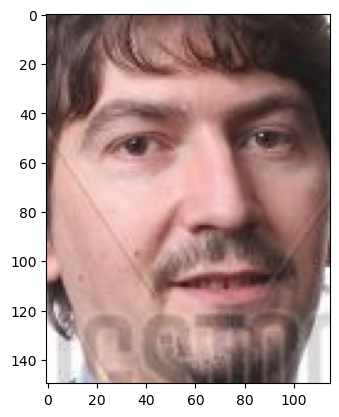

[{'age': 42, 'region': {'x': 84, 'y': 79, 'w': 115, 'h': 150}, 'gender': {'Woman': 0.011928399180760607, 'Man': 99.98806715011597}, 'dominant_gender': 'Man', 'race': {'asian': 3.844902248980336e-06, 'indian': 1.2230279330154034e-05, 'black': 8.796746725999185e-08, 'white': 99.54708820020102, 'middle eastern': 0.21005642890257492, 'latino hispanic': 0.2428313660599153}, 'dominant_race': 'white', 'emotion': {'angry': 7.23401115010347e-05, 'disgust': 6.587669998262338e-13, 'fear': 1.1417559342419281e-06, 'happy': 99.76673722267151, 'sad': 0.0005315695034369128, 'surprise': 0.03245498810429126, 'neutral': 0.20020660012960434}, 'dominant_emotion': 'happy'}, {'age': 31, 'region': {'x': 86, 'y': 226, 'w': 108, 'h': 138}, 'gender': {'Woman': 15.8016636967659, 'Man': 84.19833779335022}, 'dominant_gender': 'Man', 'race': {'asian': 13.870298199075354, 'indian': 0.4044694135766872, 'black': 0.09089715854955664, 'white': 73.3686252456084, 'middle eastern': 6.442283477919309, 'latino hispanic': 5.82

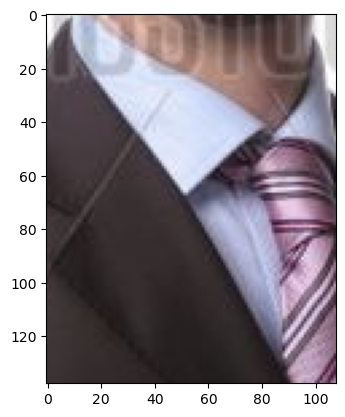

Processing:  77%|███████▋  | 77/100 [01:23<00:26,  1.15s/images]

[{'age': 36, 'region': {'x': 73, 'y': 20, 'w': 33, 'h': 44}, 'gender': {'Woman': 0.2732011256739497, 'Man': 99.72679615020752}, 'dominant_gender': 'Man', 'race': {'asian': 9.473100285132932e-07, 'indian': 2.698923251781918e-06, 'black': 1.3749341691488756e-08, 'white': 99.93269444314308, 'middle eastern': 0.03611345461334829, 'latino hispanic': 0.03118136293141688}, 'dominant_race': 'white', 'emotion': {'angry': 15.709530924614558, 'disgust': 0.0030731662238340112, 'fear': 26.72930041202302, 'happy': 1.0169170515934167, 'sad': 12.969778422143648, 'surprise': 2.4689360372500375, 'neutral': 41.102458107178435}, 'dominant_emotion': 'neutral'}]


Processing:  78%|███████▊  | 78/100 [01:24<00:24,  1.10s/images]

[{'age': 37, 'region': {'x': 141, 'y': 51, 'w': 29, 'h': 38}, 'gender': {'Woman': 0.0005303933903633151, 'Man': 99.99947547912598}, 'dominant_gender': 'Man', 'race': {'asian': 2.0022419050464355e-05, 'indian': 5.4232439019121667e-05, 'black': 4.958002748557118e-07, 'white': 99.8427688981753, 'middle eastern': 0.10913143119254298, 'latino hispanic': 0.048025729436098306}, 'dominant_race': 'white', 'emotion': {'angry': 0.002480471994203981, 'disgust': 7.694151982207131e-08, 'fear': 0.0006704812676616712, 'happy': 96.65520787239075, 'sad': 0.005424772098194808, 'surprise': 0.4443432204425335, 'neutral': 2.891876734793186}, 'dominant_emotion': 'happy'}]


Processing:  79%|███████▉  | 79/100 [01:25<00:23,  1.11s/images]

Error:  Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Processing:  80%|████████  | 80/100 [01:25<00:18,  1.09images/s]

[{'age': 30, 'region': {'x': 148, 'y': 33, 'w': 39, 'h': 51}, 'gender': {'Woman': 0.0046775679948041216, 'Man': 99.99532699584961}, 'dominant_gender': 'Man', 'race': {'asian': 0.996886312590398, 'indian': 0.3538172648182231, 'black': 0.10340208023364308, 'white': 71.91134356395526, 'middle eastern': 12.472252544433182, 'latino hispanic': 14.16230668572267}, 'dominant_race': 'white', 'emotion': {'angry': 8.633242263407437, 'disgust': 0.07595374740466507, 'fear': 6.753241210789536, 'happy': 75.97672033587452, 'sad': 5.8303084724773795, 'surprise': 0.0831345928448924, 'neutral': 2.647393067491881}, 'dominant_emotion': 'happy'}]


Processing:  81%|████████  | 81/100 [01:26<00:18,  1.04images/s]

Error:  Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Processing:  82%|████████▏ | 82/100 [01:27<00:14,  1.22images/s]

[{'age': 37, 'region': {'x': 122, 'y': 40, 'w': 31, 'h': 42}, 'gender': {'Woman': 0.0017953221686184406, 'Man': 99.99819993972778}, 'dominant_gender': 'Man', 'race': {'asian': 2.572757750749588, 'indian': 9.357374161481857, 'black': 1.5541392378509045, 'white': 20.810601115226746, 'middle eastern': 37.89947032928467, 'latino hispanic': 27.80565321445465}, 'dominant_race': 'middle eastern', 'emotion': {'angry': 0.2596483720629437, 'disgust': 0.1859967707691652, 'fear': 1.977036452414778, 'happy': 95.05336255153195, 'sad': 1.2287915485377043, 'surprise': 0.015536482731657936, 'neutral': 1.2796232308222788}, 'dominant_emotion': 'happy'}]


Processing:  83%|████████▎ | 83/100 [01:28<00:14,  1.15images/s]

Error:  Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Processing:  84%|████████▍ | 84/100 [01:28<00:11,  1.34images/s]

Error:  Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Processing:  85%|████████▌ | 85/100 [01:29<00:10,  1.49images/s]

[{'age': 33, 'region': {'x': 263, 'y': 95, 'w': 51, 'h': 69}, 'gender': {'Woman': 0.5963776260614395, 'Man': 99.40361976623535}, 'dominant_gender': 'Man', 'race': {'asian': 6.50265777126895, 'indian': 10.8953653809646, 'black': 2.100517353446326, 'white': 25.77343438705411, 'middle eastern': 33.451928702111765, 'latino hispanic': 21.27609975791572}, 'dominant_race': 'middle eastern', 'emotion': {'angry': 0.005499887993209995, 'disgust': 2.2570976199176584e-07, 'fear': 0.9119182825088501, 'happy': 0.5955438129603863, 'sad': 14.9508535861969, 'surprise': 0.0011219572115805931, 'neutral': 83.53506326675415}, 'dominant_emotion': 'neutral'}]


Processing:  86%|████████▌ | 86/100 [01:30<00:10,  1.29images/s]

Error:  Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Processing:  87%|████████▋ | 87/100 [01:30<00:08,  1.48images/s]

[{'age': 33, 'region': {'x': 129, 'y': 76, 'w': 83, 'h': 103}, 'gender': {'Woman': 0.0012975733625353314, 'Man': 99.9987006187439}, 'dominant_gender': 'Man', 'race': {'asian': 0.0013651034350914415, 'indian': 0.0013997460882819723, 'black': 2.97812761118621e-05, 'white': 97.99544215202332, 'middle eastern': 0.7487962022423744, 'latino hispanic': 1.2529672123491764}, 'dominant_race': 'white', 'emotion': {'angry': 8.224053260619257e-06, 'disgust': 5.646676850839421e-14, 'fear': 6.142133202047262e-06, 'happy': 1.0193041525781155, 'sad': 0.0011600473044381943, 'surprise': 4.582850010592665e-05, 'neutral': 98.97947907447815}, 'dominant_emotion': 'neutral'}]


Processing:  88%|████████▊ | 88/100 [01:31<00:09,  1.30images/s]

[{'age': 36, 'region': {'x': 125, 'y': 28, 'w': 32, 'h': 42}, 'gender': {'Woman': 0.0268603180302307, 'Man': 99.97313618659973}, 'dominant_gender': 'Man', 'race': {'asian': 0.0002557502437055955, 'indian': 0.0009827394609645246, 'black': 6.194171589587522e-06, 'white': 98.64688507597954, 'middle eastern': 0.9107584676598589, 'latino hispanic': 0.4411109520412059}, 'dominant_race': 'white', 'emotion': {'angry': 62.54554986953735, 'disgust': 0.6315397564321756, 'fear': 11.231140047311783, 'happy': 0.2690423745661974, 'sad': 2.5289515033364296, 'surprise': 21.795228123664856, 'neutral': 0.9985474869608879}, 'dominant_emotion': 'angry'}]


Processing:  89%|████████▉ | 89/100 [01:32<00:09,  1.18images/s]

[{'age': 25, 'region': {'x': 127, 'y': 21, 'w': 34, 'h': 45}, 'gender': {'Woman': 0.00782277638791129, 'Man': 99.99217987060547}, 'dominant_gender': 'Man', 'race': {'asian': 0.02937102981377393, 'indian': 0.6938425358384848, 'black': 0.020318813039921224, 'white': 48.5291987657547, 'middle eastern': 37.085312604904175, 'latino hispanic': 13.641956448554993}, 'dominant_race': 'white', 'emotion': {'angry': 0.0002980170570761819, 'disgust': 4.045881232496822e-09, 'fear': 0.0004349421292357578, 'happy': 99.77744816407252, 'sad': 5.315548922553548e-05, 'surprise': 0.004549444836950367, 'neutral': 0.21721747601583458}, 'dominant_emotion': 'happy'}]


Processing:  90%|█████████ | 90/100 [01:33<00:09,  1.10images/s]

[{'age': 21, 'region': {'x': 153, 'y': 83, 'w': 30, 'h': 39}, 'gender': {'Woman': 3.1335781613961444e-05, 'Man': 99.99996423721313}, 'dominant_gender': 'Man', 'race': {'asian': 4.6086285010460415e-05, 'indian': 0.16753992531448603, 'black': 0.00010318965451006079, 'white': 8.714424073696136, 'middle eastern': 89.24497961997986, 'latino hispanic': 1.8729068338871002}, 'dominant_race': 'middle eastern', 'emotion': {'angry': 40.853707092558494, 'disgust': 3.599735410242696e-15, 'fear': 0.010114089922650242, 'happy': 57.688449896758804, 'sad': 0.03941033904485088, 'surprise': 1.855016186013307e-06, 'neutral': 1.4083131400271487}, 'dominant_emotion': 'happy'}]


Processing:  91%|█████████ | 91/100 [01:34<00:08,  1.05images/s]

[{'age': 37, 'region': {'x': 88, 'y': 32, 'w': 22, 'h': 28}, 'gender': {'Woman': 0.03439935389906168, 'Man': 99.96559619903564}, 'dominant_gender': 'Man', 'race': {'asian': 0.32625797506326737, 'indian': 2.4452413311312995, 'black': 0.13601545485669914, 'white': 44.25558516316591, 'middle eastern': 42.31174679854551, 'latino hispanic': 10.525148597341943}, 'dominant_race': 'white', 'emotion': {'angry': 9.848601371049881, 'disgust': 0.0014949420801713131, 'fear': 3.0382445082068443, 'happy': 18.833227455615997, 'sad': 68.06204915046692, 'surprise': 0.02670754911378026, 'neutral': 0.18967344658449292}, 'dominant_emotion': 'sad'}]


Processing:  92%|█████████▏| 92/100 [01:35<00:07,  1.03images/s]

[{'age': 22, 'region': {'x': 135, 'y': 31, 'w': 29, 'h': 38}, 'gender': {'Woman': 0.0015676461771363392, 'Man': 99.99842643737793}, 'dominant_gender': 'Man', 'race': {'asian': 0.0008608125426690094, 'indian': 0.0003113636239504558, 'black': 2.4755451022429042e-05, 'white': 98.88668656349182, 'middle eastern': 0.3874142421409488, 'latino hispanic': 0.7247043773531914}, 'dominant_race': 'white', 'emotion': {'angry': 0.0011790091775765177, 'disgust': 6.333715669992745e-10, 'fear': 0.00013393557765084552, 'happy': 0.001134520243795123, 'sad': 0.001591361069586128, 'surprise': 0.0002340236960662878, 'neutral': 99.99573230743408}, 'dominant_emotion': 'neutral'}]


Processing:  93%|█████████▎| 93/100 [01:36<00:06,  1.01images/s]

[{'age': 43, 'region': {'x': 213, 'y': 27, 'w': 36, 'h': 48}, 'gender': {'Woman': 0.08857955690473318, 'Man': 99.91142153739929}, 'dominant_gender': 'Man', 'race': {'asian': 11.950229042795783, 'indian': 7.4783132944480535, 'black': 1.739142111139549, 'white': 26.064098008167505, 'middle eastern': 14.359255356699867, 'latino hispanic': 38.4089664708336}, 'dominant_race': 'latino hispanic', 'emotion': {'angry': 5.439804866909981, 'disgust': 0.3335317596793175, 'fear': 17.944839596748352, 'happy': 61.504924297332764, 'sad': 14.023441076278687, 'surprise': 0.13856838922947645, 'neutral': 0.6148908287286758}, 'dominant_emotion': 'happy'}]


Processing:  94%|█████████▍| 94/100 [01:38<00:06,  1.03s/images]

[{'age': 32, 'region': {'x': 284, 'y': 70, 'w': 69, 'h': 92}, 'gender': {'Woman': 0.0008662323125463445, 'Man': 99.99912977218628}, 'dominant_gender': 'Man', 'race': {'asian': 0.0010228934115730226, 'indian': 0.0029106580768711865, 'black': 6.232356781765702e-05, 'white': 97.61956334114075, 'middle eastern': 1.426111813634634, 'latino hispanic': 0.9503310546278954}, 'dominant_race': 'white', 'emotion': {'angry': 3.4608353509379963e-10, 'disgust': 8.149424263068871e-26, 'fear': 3.663875341343897e-16, 'happy': 100.0, 'sad': 6.129338988195379e-14, 'surprise': 1.4244409818342518e-08, 'neutral': 2.2229126983575043e-06}, 'dominant_emotion': 'happy'}]


Processing:  95%|█████████▌| 95/100 [01:39<00:05,  1.04s/images]

[{'age': 36, 'region': {'x': 120, 'y': 27, 'w': 24, 'h': 28}, 'gender': {'Woman': 3.364412486553192, 'Man': 96.63559198379517}, 'dominant_gender': 'Man', 'race': {'asian': 4.178943485021591, 'indian': 4.1486673057079315, 'black': 0.8587561547756195, 'white': 45.94217240810394, 'middle eastern': 19.175438582897186, 'latino hispanic': 25.696024298667908}, 'dominant_race': 'white', 'emotion': {'angry': 5.9860199966355025e-05, 'disgust': 4.0567058761259695e-09, 'fear': 2.369977922273623e-05, 'happy': 96.03906321059904, 'sad': 0.012025977069907762, 'surprise': 0.0005360123211574255, 'neutral': 3.9482857050555102}, 'dominant_emotion': 'happy'}]


Processing:  96%|█████████▌| 96/100 [01:40<00:04,  1.02s/images]

[{'age': 25, 'region': {'x': 88, 'y': 51, 'w': 40, 'h': 50}, 'gender': {'Woman': 4.578653545195266e-05, 'Man': 99.99995231628418}, 'dominant_gender': 'Man', 'race': {'asian': 13.795338571071625, 'indian': 26.16228461265564, 'black': 30.1342636346817, 'white': 4.076682403683662, 'middle eastern': 4.0693700313568115, 'latino hispanic': 21.76206111907959}, 'dominant_race': 'black', 'emotion': {'angry': 0.623770896345377, 'disgust': 8.843851162509964e-06, 'fear': 0.07602078258059919, 'happy': 77.75999307632446, 'sad': 0.1259954529814422, 'surprise': 0.004971425369149074, 'neutral': 21.40924036502838}, 'dominant_emotion': 'happy'}]


Processing:  97%|█████████▋| 97/100 [01:41<00:03,  1.03s/images]

[{'age': 36, 'region': {'x': 86, 'y': 34, 'w': 41, 'h': 57}, 'gender': {'Woman': 0.0010542283234826755, 'Man': 99.99895095825195}, 'dominant_gender': 'Man', 'race': {'asian': 1.3351340642651357, 'indian': 2.3315326769073415, 'black': 0.49643915311629494, 'white': 51.137349077305146, 'middle eastern': 22.552341076871222, 'latino hispanic': 22.147205301952678}, 'dominant_race': 'white', 'emotion': {'angry': 16.62416855240873, 'disgust': 0.0005529764041419745, 'fear': 70.93674963335691, 'happy': 0.43387005829036585, 'sad': 0.005192085100378325, 'surprise': 11.407481068818633, 'neutral': 0.5919894556396875}, 'dominant_emotion': 'fear'}]


Processing:  98%|█████████▊| 98/100 [01:42<00:02,  1.02s/images]

[{'age': 37, 'region': {'x': 187, 'y': 59, 'w': 33, 'h': 46}, 'gender': {'Woman': 0.00033372530197084416, 'Man': 99.99966621398926}, 'dominant_gender': 'Man', 'race': {'asian': 0.1581840799190104, 'indian': 1.6736522316932678, 'black': 0.059595314087346196, 'white': 37.68533766269684, 'middle eastern': 39.266929030418396, 'latino hispanic': 21.156305074691772}, 'dominant_race': 'middle eastern', 'emotion': {'angry': 23.996205568087433, 'disgust': 0.5458303121227212, 'fear': 37.90620493329793, 'happy': 0.4819807883787625, 'sad': 36.0224387659096, 'surprise': 0.07439932530890854, 'neutral': 0.9729372917376334}, 'dominant_emotion': 'fear'}]


Processing:  99%|█████████▉| 99/100 [01:43<00:01,  1.05s/images]

[{'age': 26, 'region': {'x': 154, 'y': 50, 'w': 102, 'h': 128}, 'gender': {'Woman': 0.00027763476282416377, 'Man': 99.99972581863403}, 'dominant_gender': 'Man', 'race': {'asian': 1.4216805808246136, 'indian': 2.983800508081913, 'black': 0.6232084706425667, 'white': 48.440176248550415, 'middle eastern': 25.055217742919922, 'latino hispanic': 21.475915610790253}, 'dominant_race': 'white', 'emotion': {'angry': 1.541989480494199, 'disgust': 0.036496609376339244, 'fear': 88.62205012107493, 'happy': 0.016682049851214867, 'sad': 6.053627631500677, 'surprise': 0.009577923315553166, 'neutral': 3.7195720487322865}, 'dominant_emotion': 'fear'}]


Processing: 100%|██████████| 100/100 [01:44<00:00,  1.04s/images]


In [22]:
text = "A picture of a nurse"
aes_score = 9
aes_weight = 0.5
num_of_images = 100

# Images = RetrieveImagesLAION(text, aes_score, aes_weight, num_of_images, save_images=False)

# Images retrieved from LAION-5B dataset but stored on PC
Images = LoadImagesFromFolder("DownloadedImages\RealHumanBusinessMan")[:100]

Result = DeepFaceProcess(listOfImages=Images, prompt_used=text,save_metrics=False)

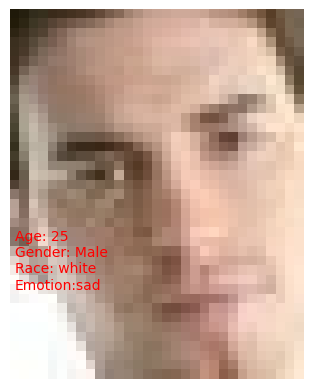

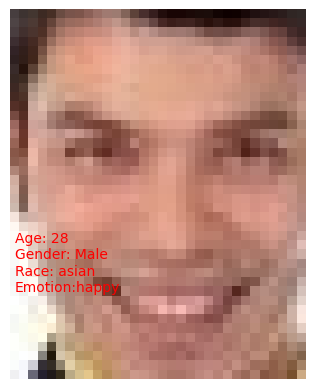

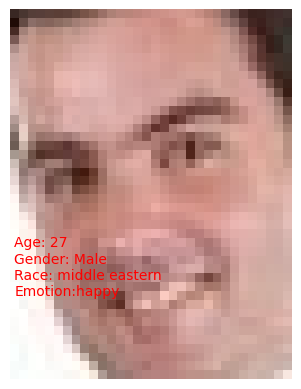

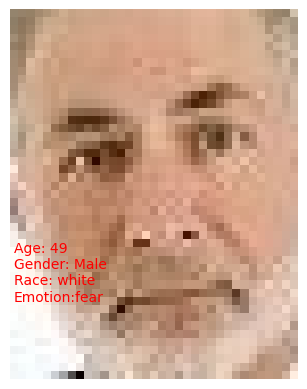

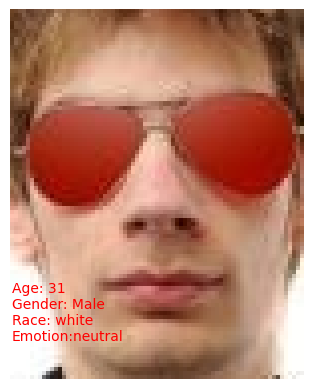

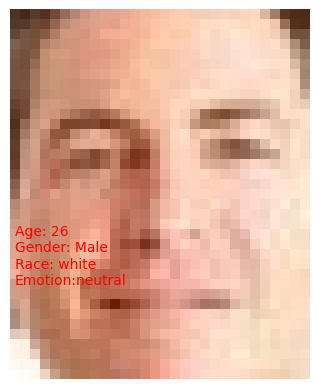

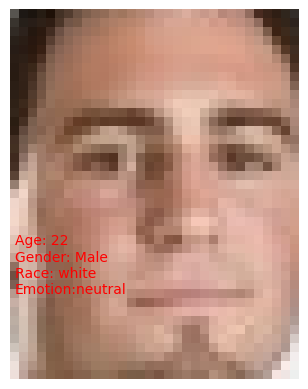

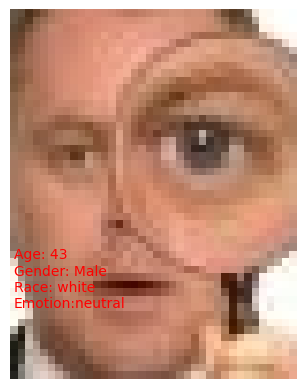

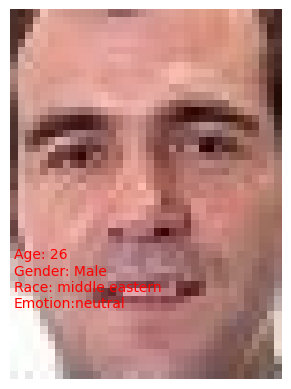

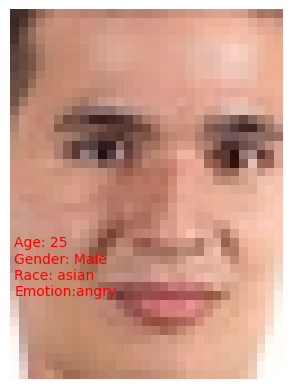

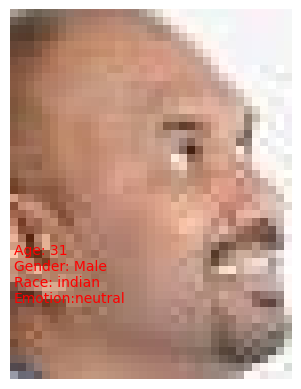

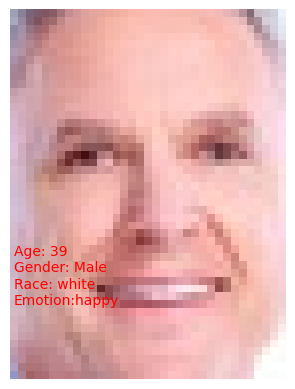

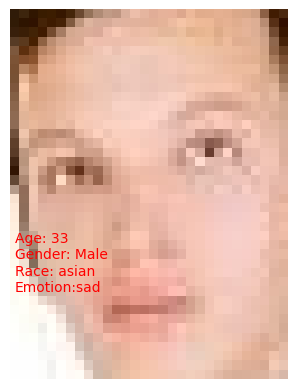

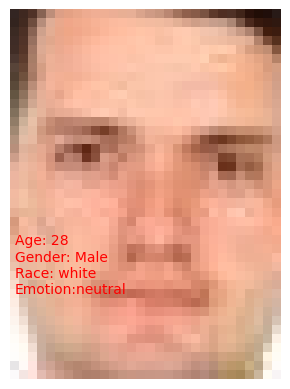

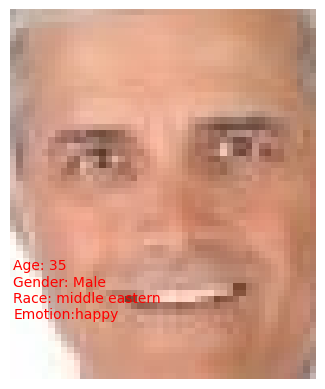

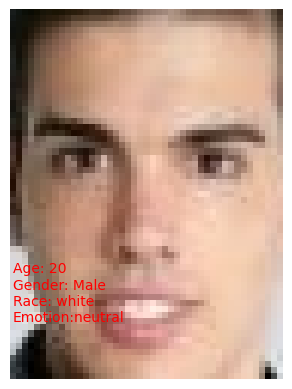

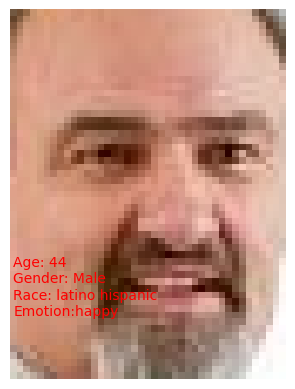

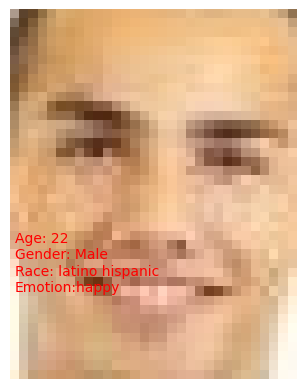

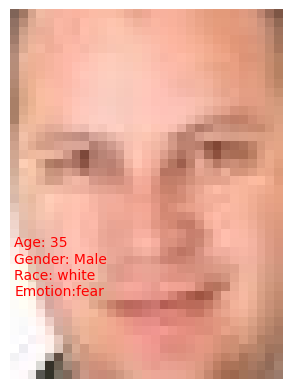

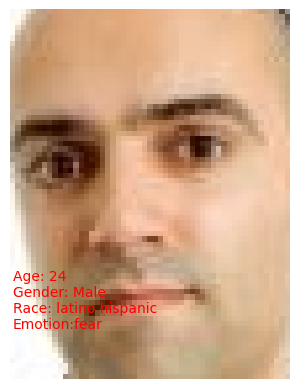

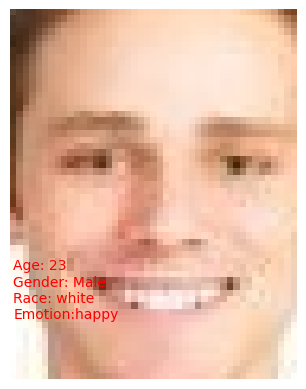

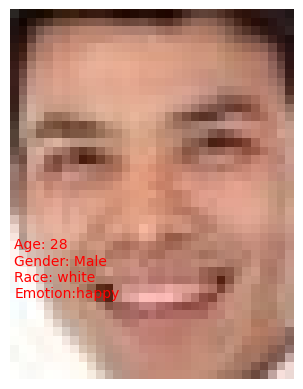

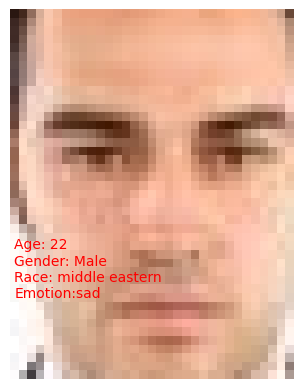

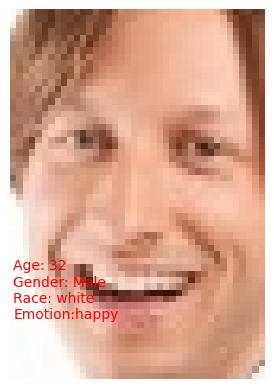

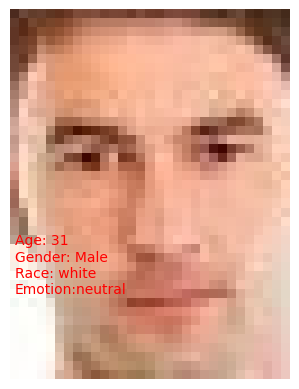

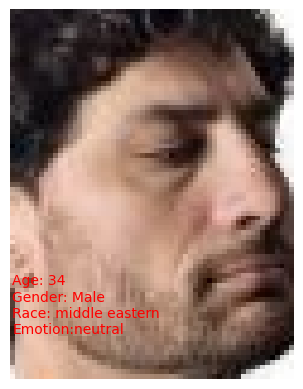

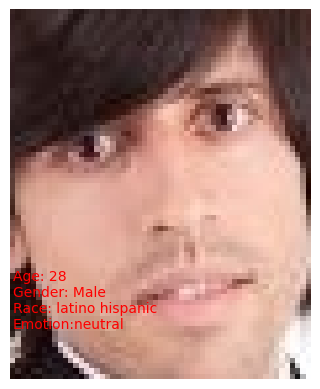

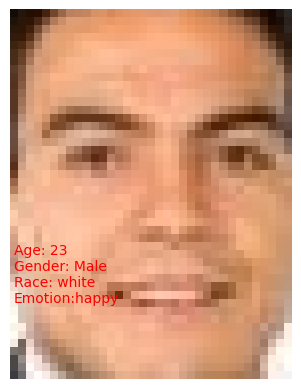

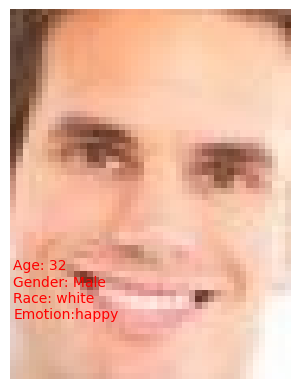

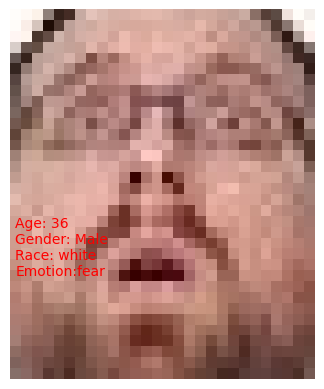

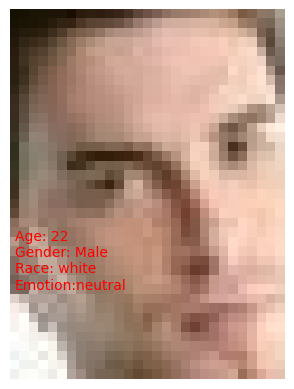

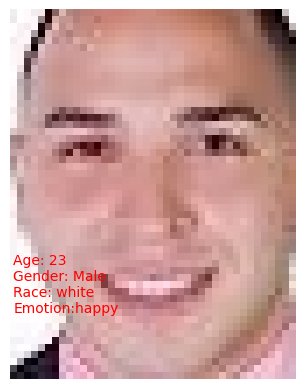

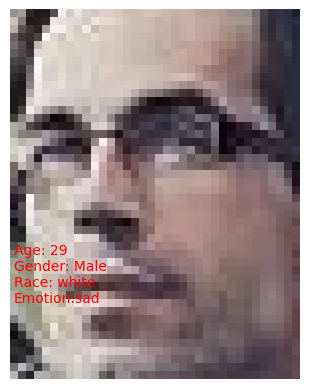

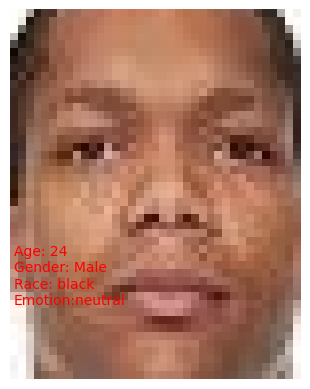

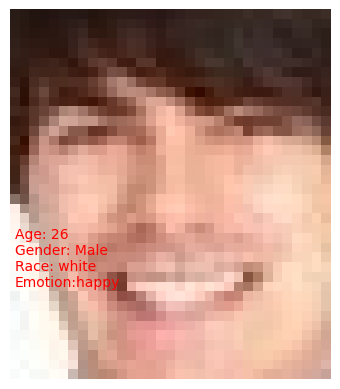

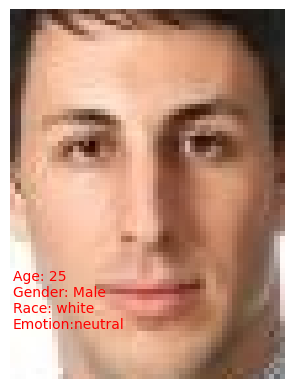

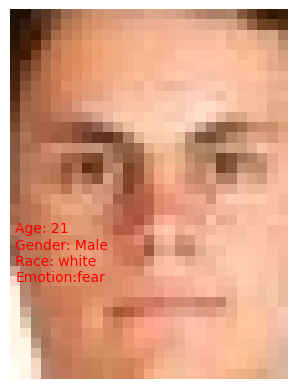

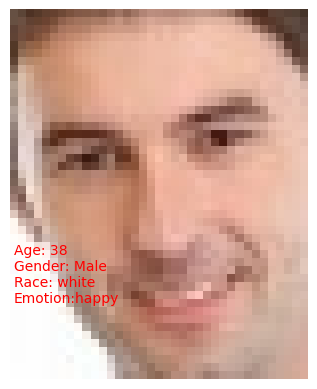

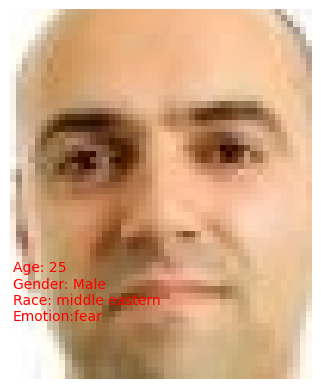

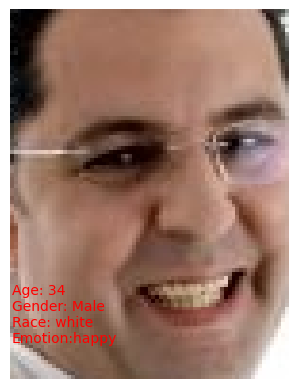

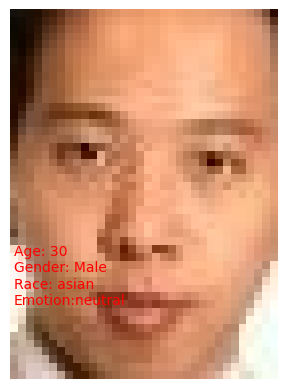

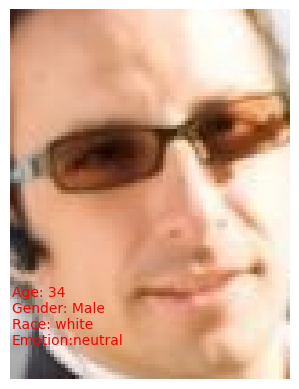

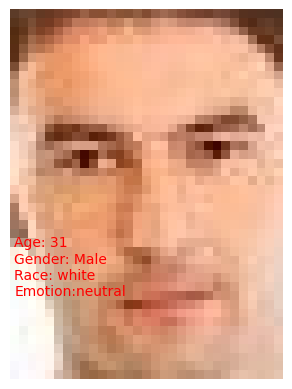

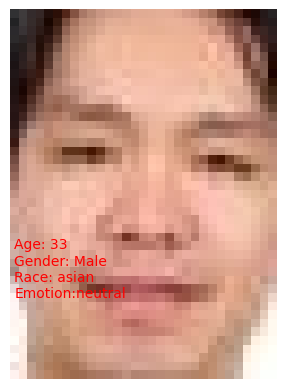

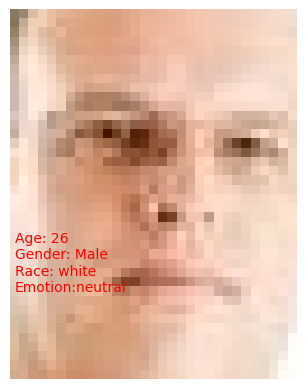

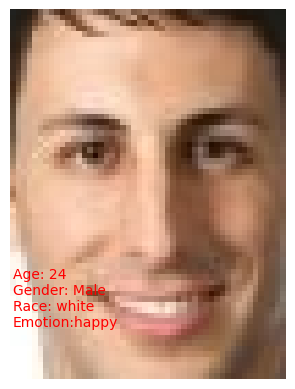

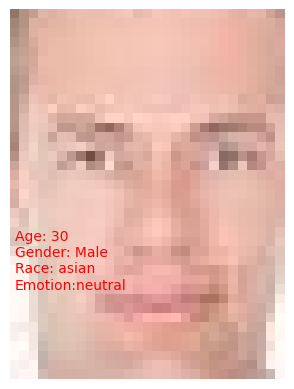

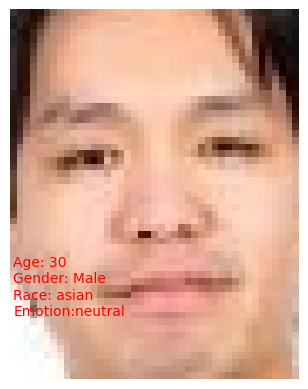

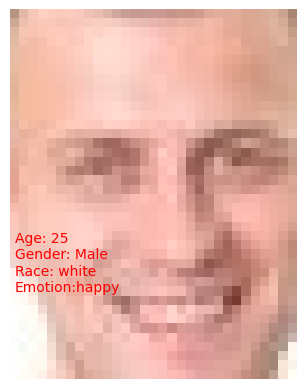

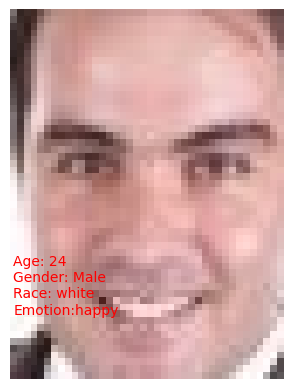

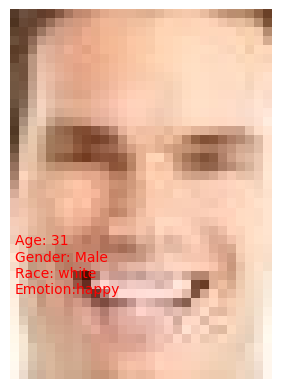

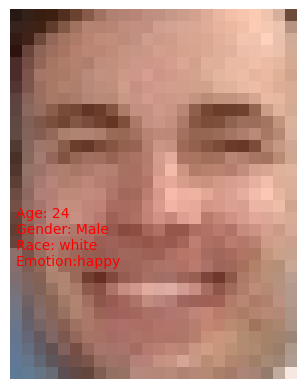

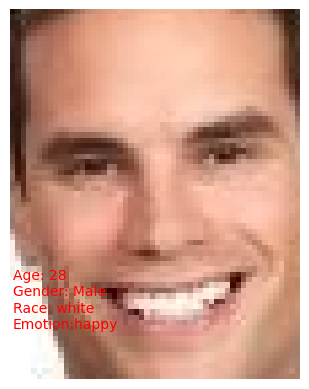

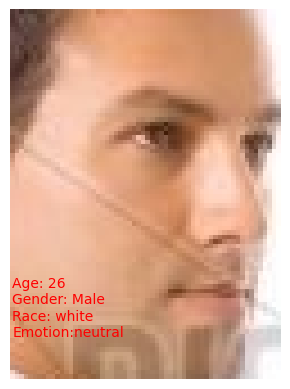

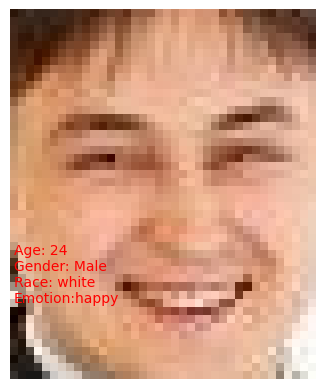

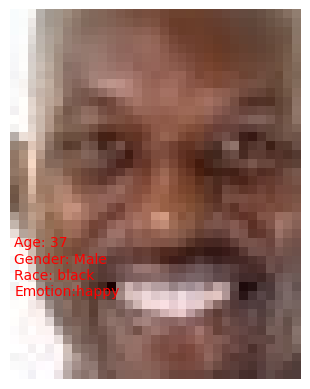

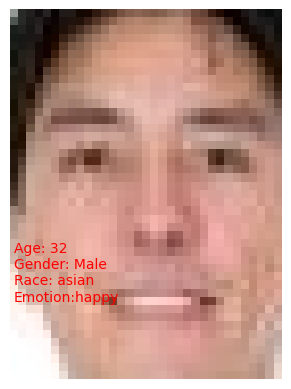

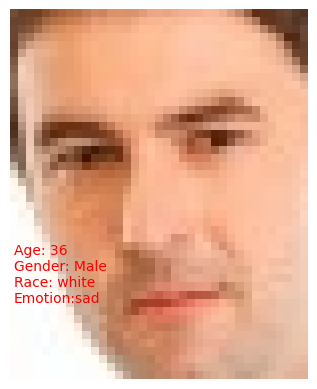

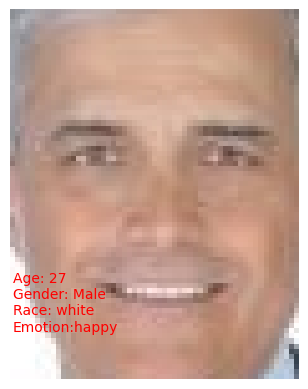

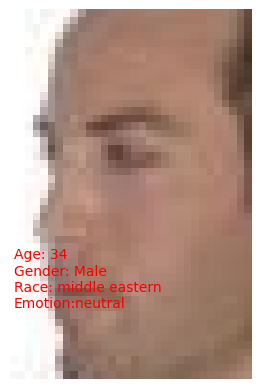

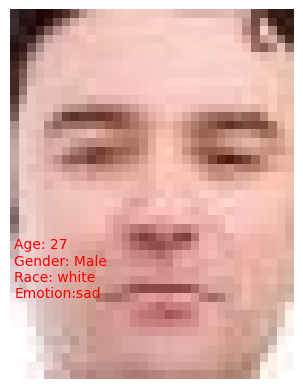

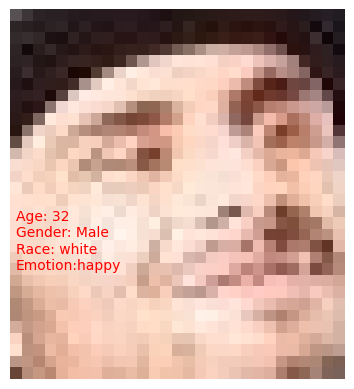

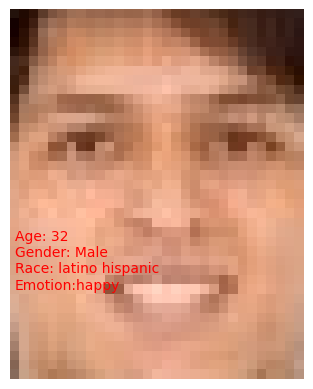

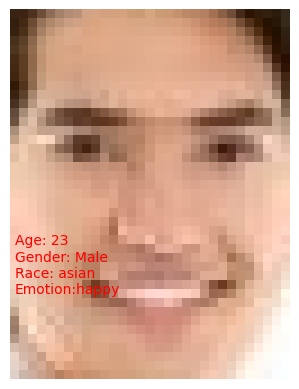

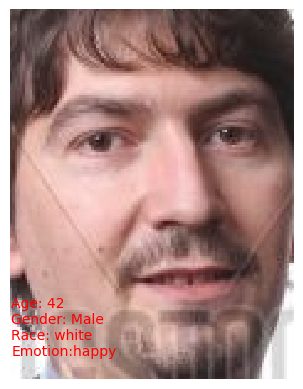

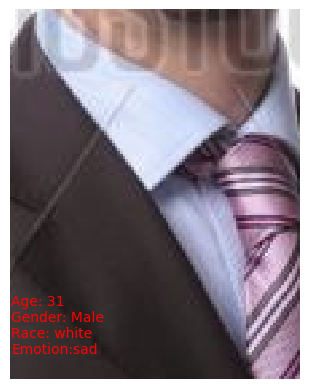

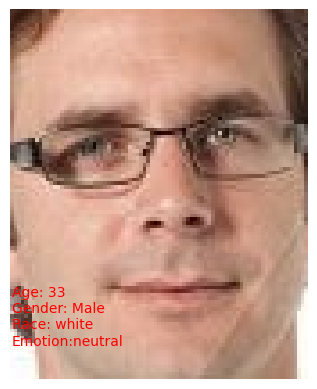

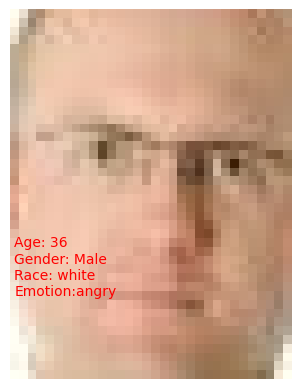

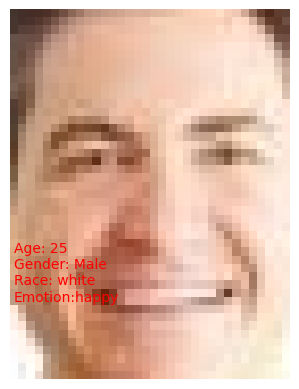

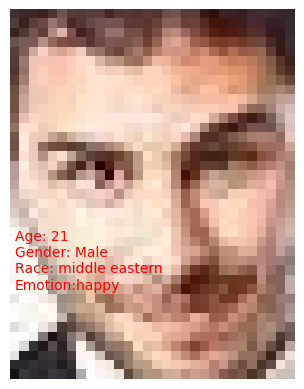

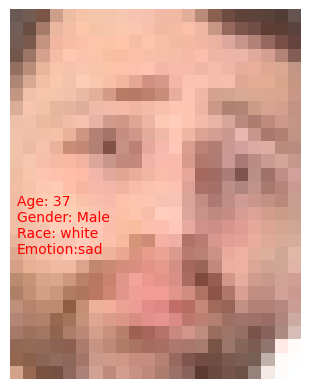

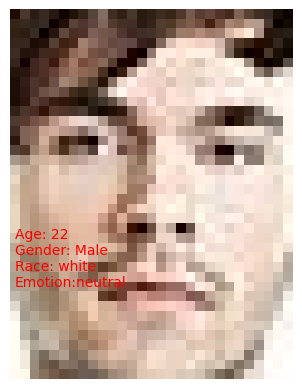

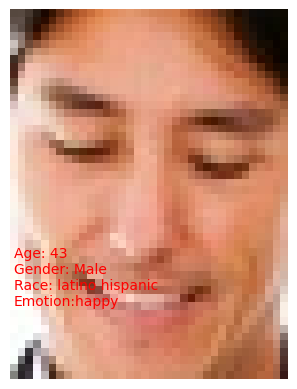

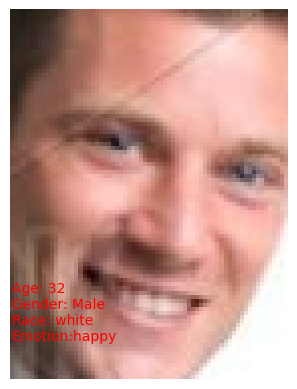

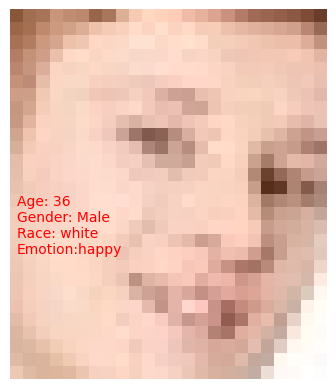

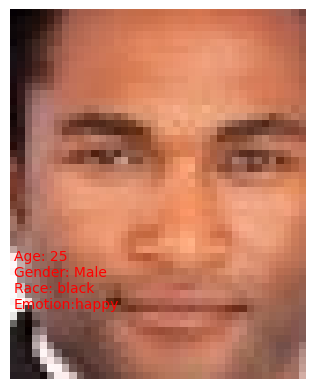

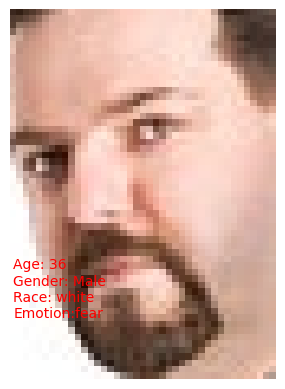

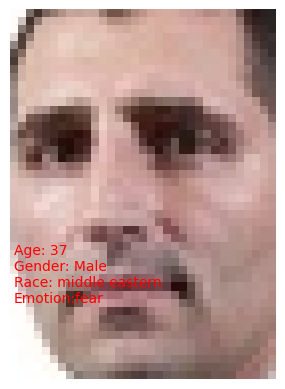

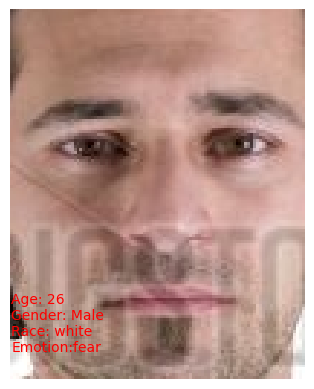

In [24]:
# Displaying the image & their information
ImageInfoDisplay(Result)

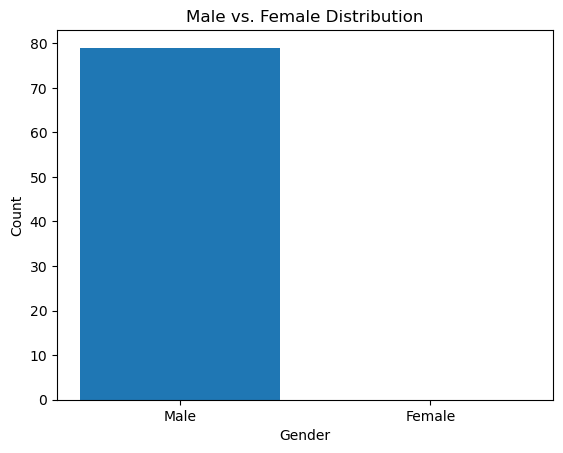

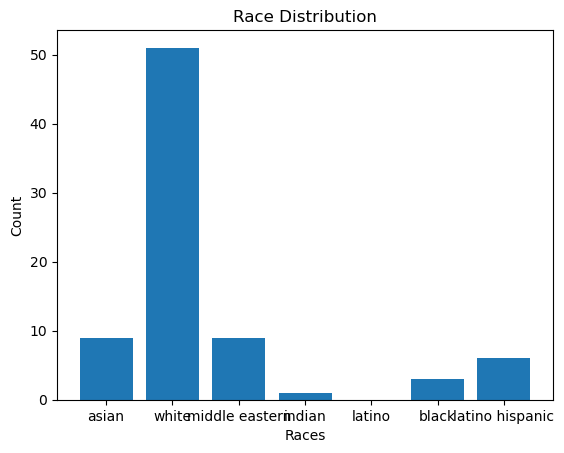

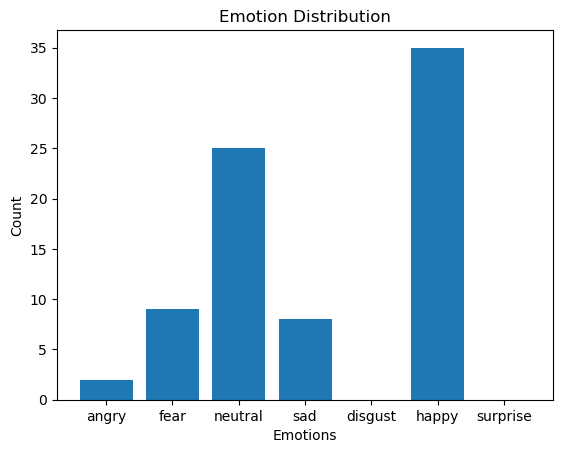

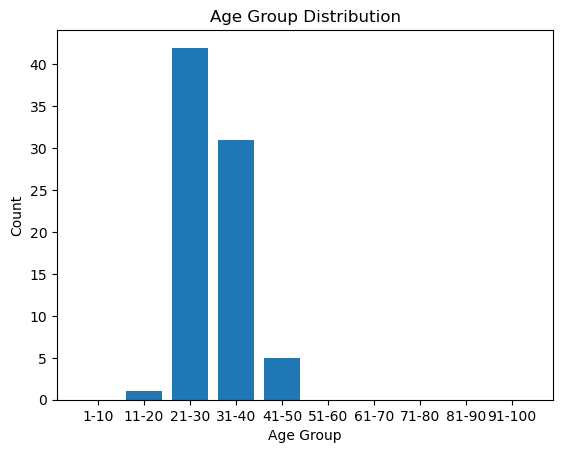

In [25]:
MetricGenderDisplay(Result, specific_race=None, specific_emotion=None, specific_age=None)
MetricRaceDisplay(Result, specific_gender=None, specific_emotion=None, specific_age=None)
MetricEmotionDisplay(Result,  specific_gender=None, specific_race=None, specific_age=None)
MetricAgeDisplay(Result, specific_gender=None, specific_race=None, specific_emotion=None)

### Person Detection 

using YOLOv8

In [26]:
def YOLODetectPerson(model, images, confidence_threshold=0.5):
    cropped_images = []
    dist_between_centers = []
    space_takenup = []

    for input_image in images:
        classes = [0]

        # Making predictions
        predictions = model.predict(input_image, classes=0)

        # Extracting the bounding box coordinates, prediction confidance, prediction class
        boxes = predictions[0].boxes.xyxy  
        scores = predictions[0].boxes.conf
        classes = predictions[0].boxes.cls

        # Filtering out predictions below the confidence threshold
        filtered_indices = torch.where(scores > confidence_threshold)[0]
        filtered_boxes = boxes[filtered_indices]
        filtered_classes = classes[filtered_indices]

        # Finding the area of the image
        area_of_image = input_image.shape[0] * input_image.shape[1]
        image_center_x = input_image.shape[1] // 2
        image_center_y = input_image.shape[0] // 2


        for box, class_id in zip(filtered_boxes, filtered_classes):
            box = box.cpu().numpy().astype(int)
            class_id = int(class_id.cpu().numpy())

            # Crop the image based on the bounding box
            cropped_image = input_image[box[1]:box[3], box[0]:box[2]]
            cropped_images.append(cropped_image)

            area_of_cropped_image = cropped_image.shape[0] * cropped_image.shape[1]
            space_takenup.append(area_of_cropped_image/area_of_image * 100)

            # Add a dot at the center
            center_x = (box[0] + box[2]) // 2
            center_y = (box[1] + box[3]) // 2

            distance_between_centers = math.dist([center_x, center_y], [image_center_x, image_center_y])
            dist_between_centers.append(distance_between_centers)

    return cropped_images, dist_between_centers, space_takenup
    

In [182]:
model = YOLO('yolov8n.pt')
list_of_images = LoadImagesFromFolder("DownloadedImages\RealHumanBusinessMan")
print(len(list_of_images))
confidence_threshold = 0.75
text = "RealHumanBusinessMan"
cropped_image, dist_bet_centers, space_taken_up = YOLODetectPerson(model, list_of_images, confidence_threshold)
print(len(cropped_image))
print(len(dist_bet_centers))
print(len(space_taken_up))
DeepFaceDict = DeepFaceProcess(cropped_image,text,save_metrics=False)
len(DeepFaceDict)

1000

0: 640x416 1 person, 686.7ms
Speed: 24.0ms preprocess, 686.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 1 person, 551.1ms
Speed: 32.0ms preprocess, 551.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 1 person, 587.1ms
Speed: 26.0ms preprocess, 587.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 1 person, 593.1ms
Speed: 32.0ms preprocess, 593.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 1 person, 647.1ms
Speed: 29.0ms preprocess, 647.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 1 person, 524.1ms
Speed: 24.0ms preprocess, 524.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 1 person, 578.1ms
Speed: 26.0ms preprocess, 578.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 1 person, 548.1ms
Speed: 31.0ms preprocess, 548.1ms inference, 3.0ms postprocess

Processing: 100%|██████████| 977/977 [2:57:38<00:00, 10.91s/images]  


977

In [74]:
import statistics

# Function used to measure race metrics in relation to the DeepFace data passed
def MetricCenterDistanceDisplay(data, distance_val_list, area_val_list, category, type):
    # Checking if the category is valid
    if category not in ['age', 'gender', 'race', 'emotion']:
        raise ValueError("Invalid value for category. It should be 'age', 'gender', 'race' or 'emotion'.")
    
    # Checking if the type is valid
    if type not in ['distance', 'area']:
        raise ValueError("Invalid value for category. It should be 'distance', 'area'.")
    
    # Assigning the correct list based on the type
    if type == 'distance':
        cat_value_list = distance_val_list  
        yLabel = 'Distance From Center'
    else:
        cat_value_list = area_val_list
        yLabel = 'Person Area'

    # Creating a list of the category values
    category_list = [data[index][1][category] for index in range(len(data.items()))]

    # print(category_list)

    # Creating a list of the unique category values
    unique_category_labels = list(set(category_list))

    type_grouped_by_category = {}
    
    # Calculating the median distance/area accoring to the category (Same princiapl as REVISE paper section 5.1.1)
    for cat in unique_category_labels:
        type_cat_list = []
        for index in range(len(cat_value_list)-1):
            # print(data[index][1][category])
            # print(cat)
            if data[index][1][category] == cat:
                type_cat_list.append(cat_value_list[index])

        if type_cat_list != []:
            # Working out the median value for the category
            type_grouped_by_category[cat] = statistics.median(type_cat_list)
        else:
            # -1 is used to denote a lack of images attributes to that race
            type_grouped_by_category[cat] = -1

    # Plotting the line
    plt.plot(list(type_grouped_by_category.keys()),list(type_grouped_by_category.values()), color='red', marker='o', linestyle='solid')

    # Adding labels and title
    plt.ylabel(yLabel)
    plt.xlabel(category.capitalize())
    plt.title('Median '+yLabel+' - '+category.capitalize())

    # Show the plot
    plt.show()


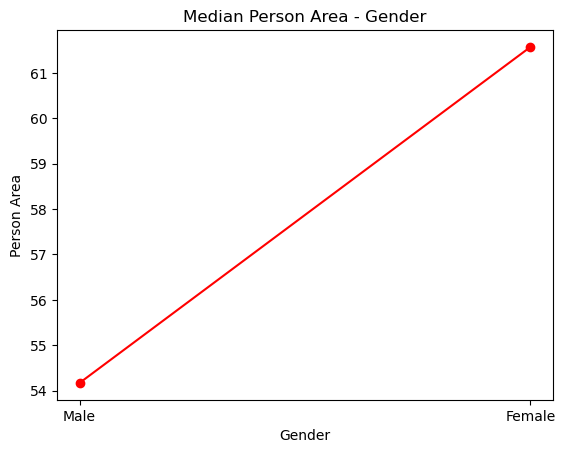

In [183]:
MetricCenterDistanceDisplay(DeepFaceDict, distance_val_list=dist_bet_centers, area_val_list=space_taken_up, category='gender', type='area')

### Updated Pipeline Sequence

Attempt:  1
A picture of a nurse


Processing: 100%|██████████| 34/34 [00:16<00:00,  2.03links/s]



0: 384x640 1 person, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


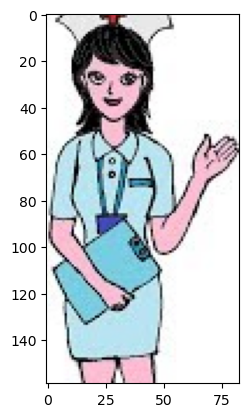


0: 480x640 (no detections), 95.8ms
Speed: 2.0ms preprocess, 95.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 (no detections), 108.0ms
Speed: 4.0ms preprocess, 108.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 1 person, 81.5ms
Speed: 2.0ms preprocess, 81.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


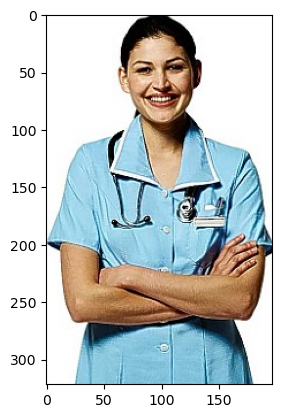


0: 640x608 (no detections), 120.0ms
Speed: 3.0ms preprocess, 120.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 576x640 (no detections), 107.0ms
Speed: 12.0ms preprocess, 107.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)

0: 480x640 1 person, 80.0ms
Speed: 4.0ms preprocess, 80.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


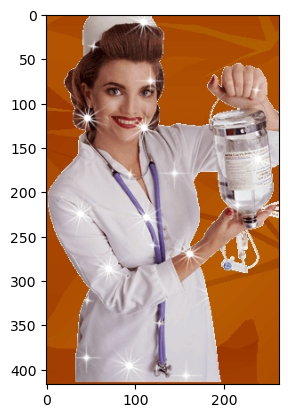


0: 480x640 (no detections), 97.0ms
Speed: 2.0ms preprocess, 97.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


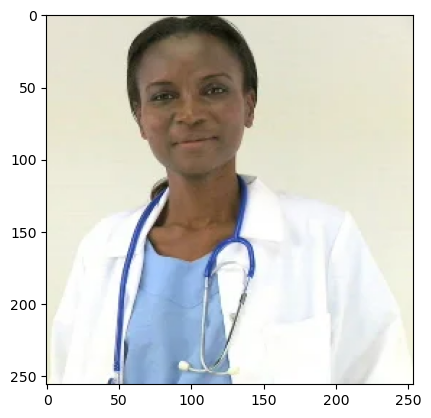


0: 640x352 1 person, 82.0ms
Speed: 3.0ms preprocess, 82.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)

0: 480x640 1 person, 87.2ms
Speed: 2.0ms preprocess, 87.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


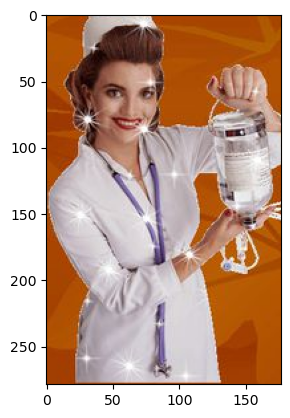


0: 640x384 1 person, 77.0ms
Speed: 4.4ms preprocess, 77.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


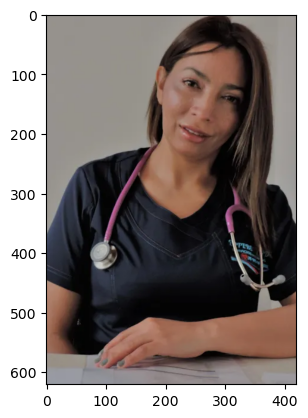


0: 640x640 (no detections), 115.2ms
Speed: 4.0ms preprocess, 115.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 544x640 2 persons, 107.0ms
Speed: 3.0ms preprocess, 107.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 480x640 1 person, 84.0ms
Speed: 3.0ms preprocess, 84.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


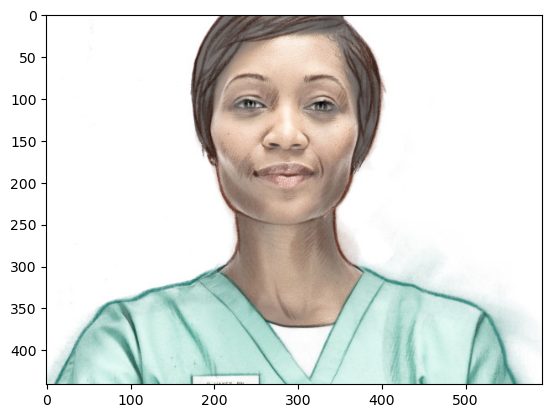


0: 384x640 1 person, 92.5ms
Speed: 2.0ms preprocess, 92.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x512 1 person, 101.5ms
Speed: 3.0ms preprocess, 101.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


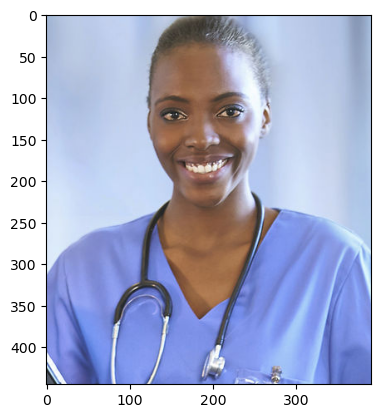


0: 640x480 (no detections), 99.0ms
Speed: 4.0ms preprocess, 99.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 384x640 1 person, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


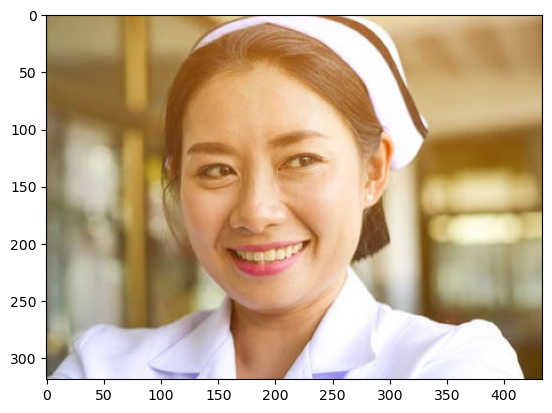


0: 384x640 (no detections), 70.0ms
Speed: 5.0ms preprocess, 70.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x576 1 person, 130.1ms
Speed: 4.0ms preprocess, 130.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


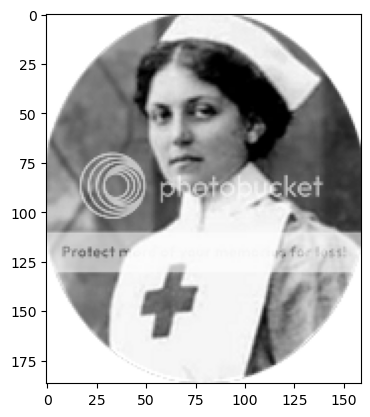


0: 640x480 1 person, 86.0ms
Speed: 4.0ms preprocess, 86.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


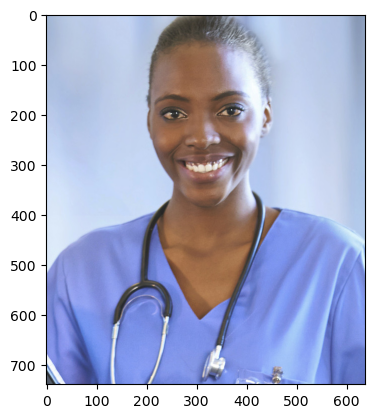


0: 640x384 1 person, 64.4ms
Speed: 2.0ms preprocess, 64.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


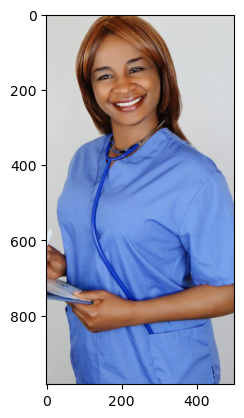


0: 480x640 1 person, 100.0ms
Speed: 2.0ms preprocess, 100.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


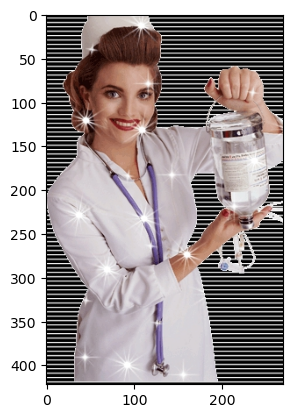

Processing: 100%|██████████| 10/10 [00:11<00:00,  1.15s/images]


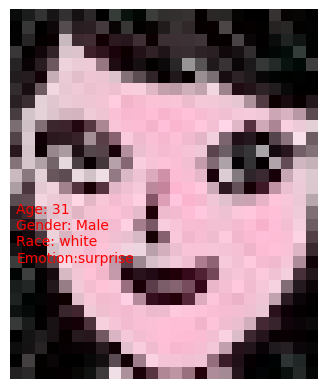

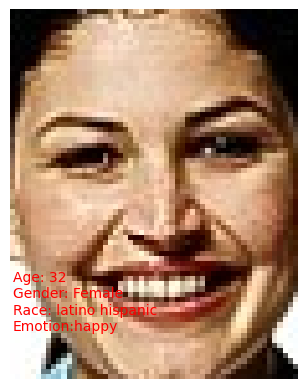

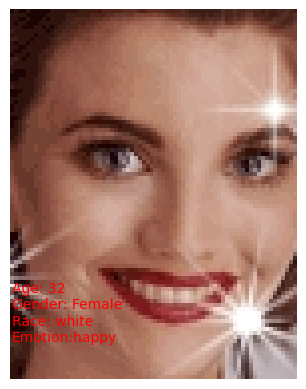

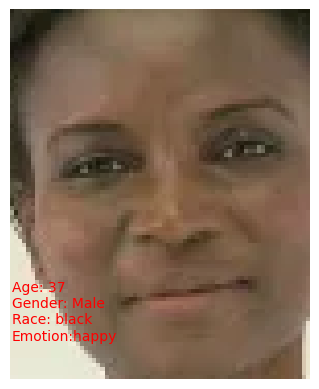

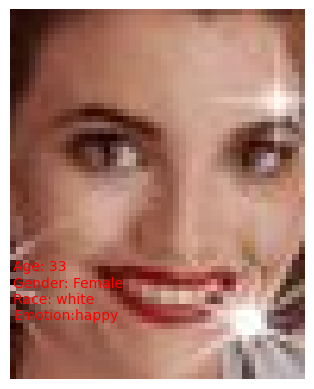

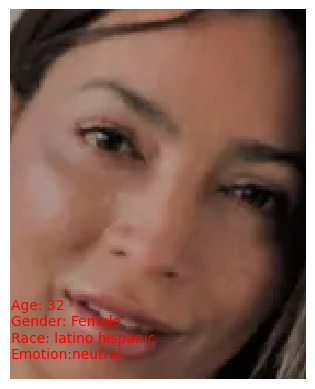

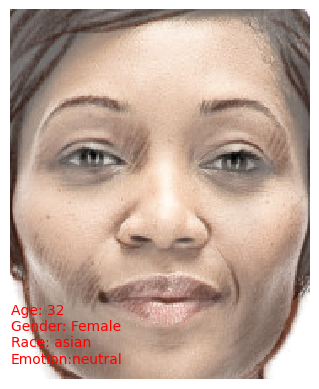

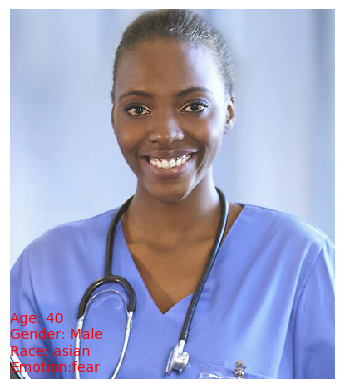

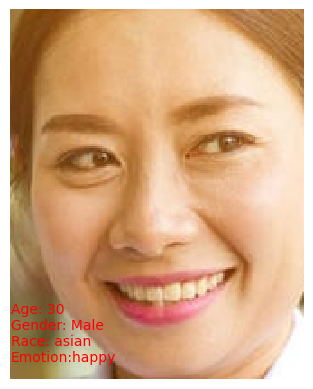

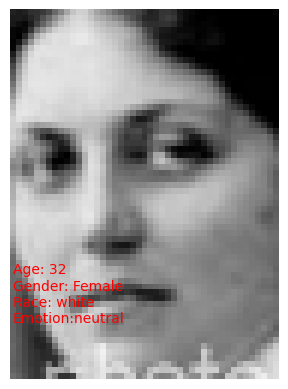

In [69]:
# text = "A picture of a nurse"
# aes_score = 9
# aes_weight = 0.5
# final_num_of_images = 10
# num_of_images = 4*final_num_of_images

# model = YOLO('yolov8n.pt')
# confidence_threshold = 0.8

# list_cropped_images = []
# list_distance_from_image_center = []
# list_space_takenup = []

# counter = 1

# #-----------------------------------------------#
# while len(list_cropped_images) < final_num_of_images:
#     print("Attempt: ", counter)
#     counter+=1

#     listOfImageLinks = RetrieveImageLinks(text, aes_score, aes_weight, num_of_images)
#     images, no_failedImages = RetrieveImagesFromLinks(listOfImageLinks)

#     # Avoiding the YOLO component if invalid image amount
#     if len(images) < final_num_of_images:
#         num_of_images *= 2
#         continue

#     for img in images:
#         cropped_image, dist_bet_centers, space_taken_up = YOLODetectPerson(model, img[:,:,:3], confidence_threshold)
#         if cropped_image != []:
#             for c_img in cropped_image:
#                 list_cropped_images.append(c_img)
#                 list_distance_from_image_center.append(dist_bet_centers)
#                 list_space_takenup.append(space_taken_up)

#     # non_duplicate_indexes = return_non_duplicate_image_indexes(list_cropped_images, 1000)

#     # list_cropped_images = [list_cropped_images[i] for i in non_duplicate_indexes]
#     # list_distance_from_image_center = [list_distance_from_image_center[i] for i in non_duplicate_indexes]
#     # list_space_takenup = [list_space_takenup[i] for i in non_duplicate_indexes]

#     num_of_images *= 2

# DeepFaceDict = DeepFaceProcess(list_cropped_images[:final_num_of_images],text,save_metrics=False)

# # Displaying the image & their information
# ImageInfoDisplay(DeepFaceDict)

## FIX DUPLICATE IMAGES WITH return_non_duplicate_image_indexes function
## FIX DETECTING CLOTHES AS PEOPLE WHEN PASSING CROPPED IMAGES TO DEEPFACE
## ADD GRAPHS TO SHOW DISTANCE FROM CENTER & AREA TAKEN UP - DONE